This notebook will allow us to visualize convolution networks

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# --- Load MNIST dataset ---
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.40MB/s]


In [ ]:
metrics = {}

In [ ]:
def evaluate(model, loader, criterion):
    model.eval()
    correct, total, total_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            total_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    avg_loss = total_loss / len(loader)
    return acc, avg_loss


def train(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = SimpleCNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    num_epochs = 5

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_acc, train_loss = evaluate(model, train_loader, criterion)
        test_acc, test_loss = evaluate(model, test_loader, criterion)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.2f}%")
    return model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Network 1: FC network with no hidden Units

## Model Training

In [ ]:
class FC_Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten
        return self.fc(x)

model = train(FC_Linear().to(device)) # Replace with model of interest

Epoch 1/5
  Train Loss: 0.3465, Train Acc: 90.62%
  Test  Loss: 0.3319, Test  Acc: 90.88%
Epoch 2/5
  Train Loss: 0.2997, Train Acc: 91.67%
  Test  Loss: 0.2933, Test  Acc: 91.73%
Epoch 3/5
  Train Loss: 0.2828, Train Acc: 92.20%
  Test  Loss: 0.2812, Test  Acc: 92.08%
Epoch 4/5
  Train Loss: 0.2729, Train Acc: 92.39%
  Test  Loss: 0.2745, Test  Acc: 92.32%
Epoch 5/5
  Train Loss: 0.2670, Train Acc: 92.57%
  Test  Loss: 0.2717, Test  Acc: 92.35%


## Weights Visualization


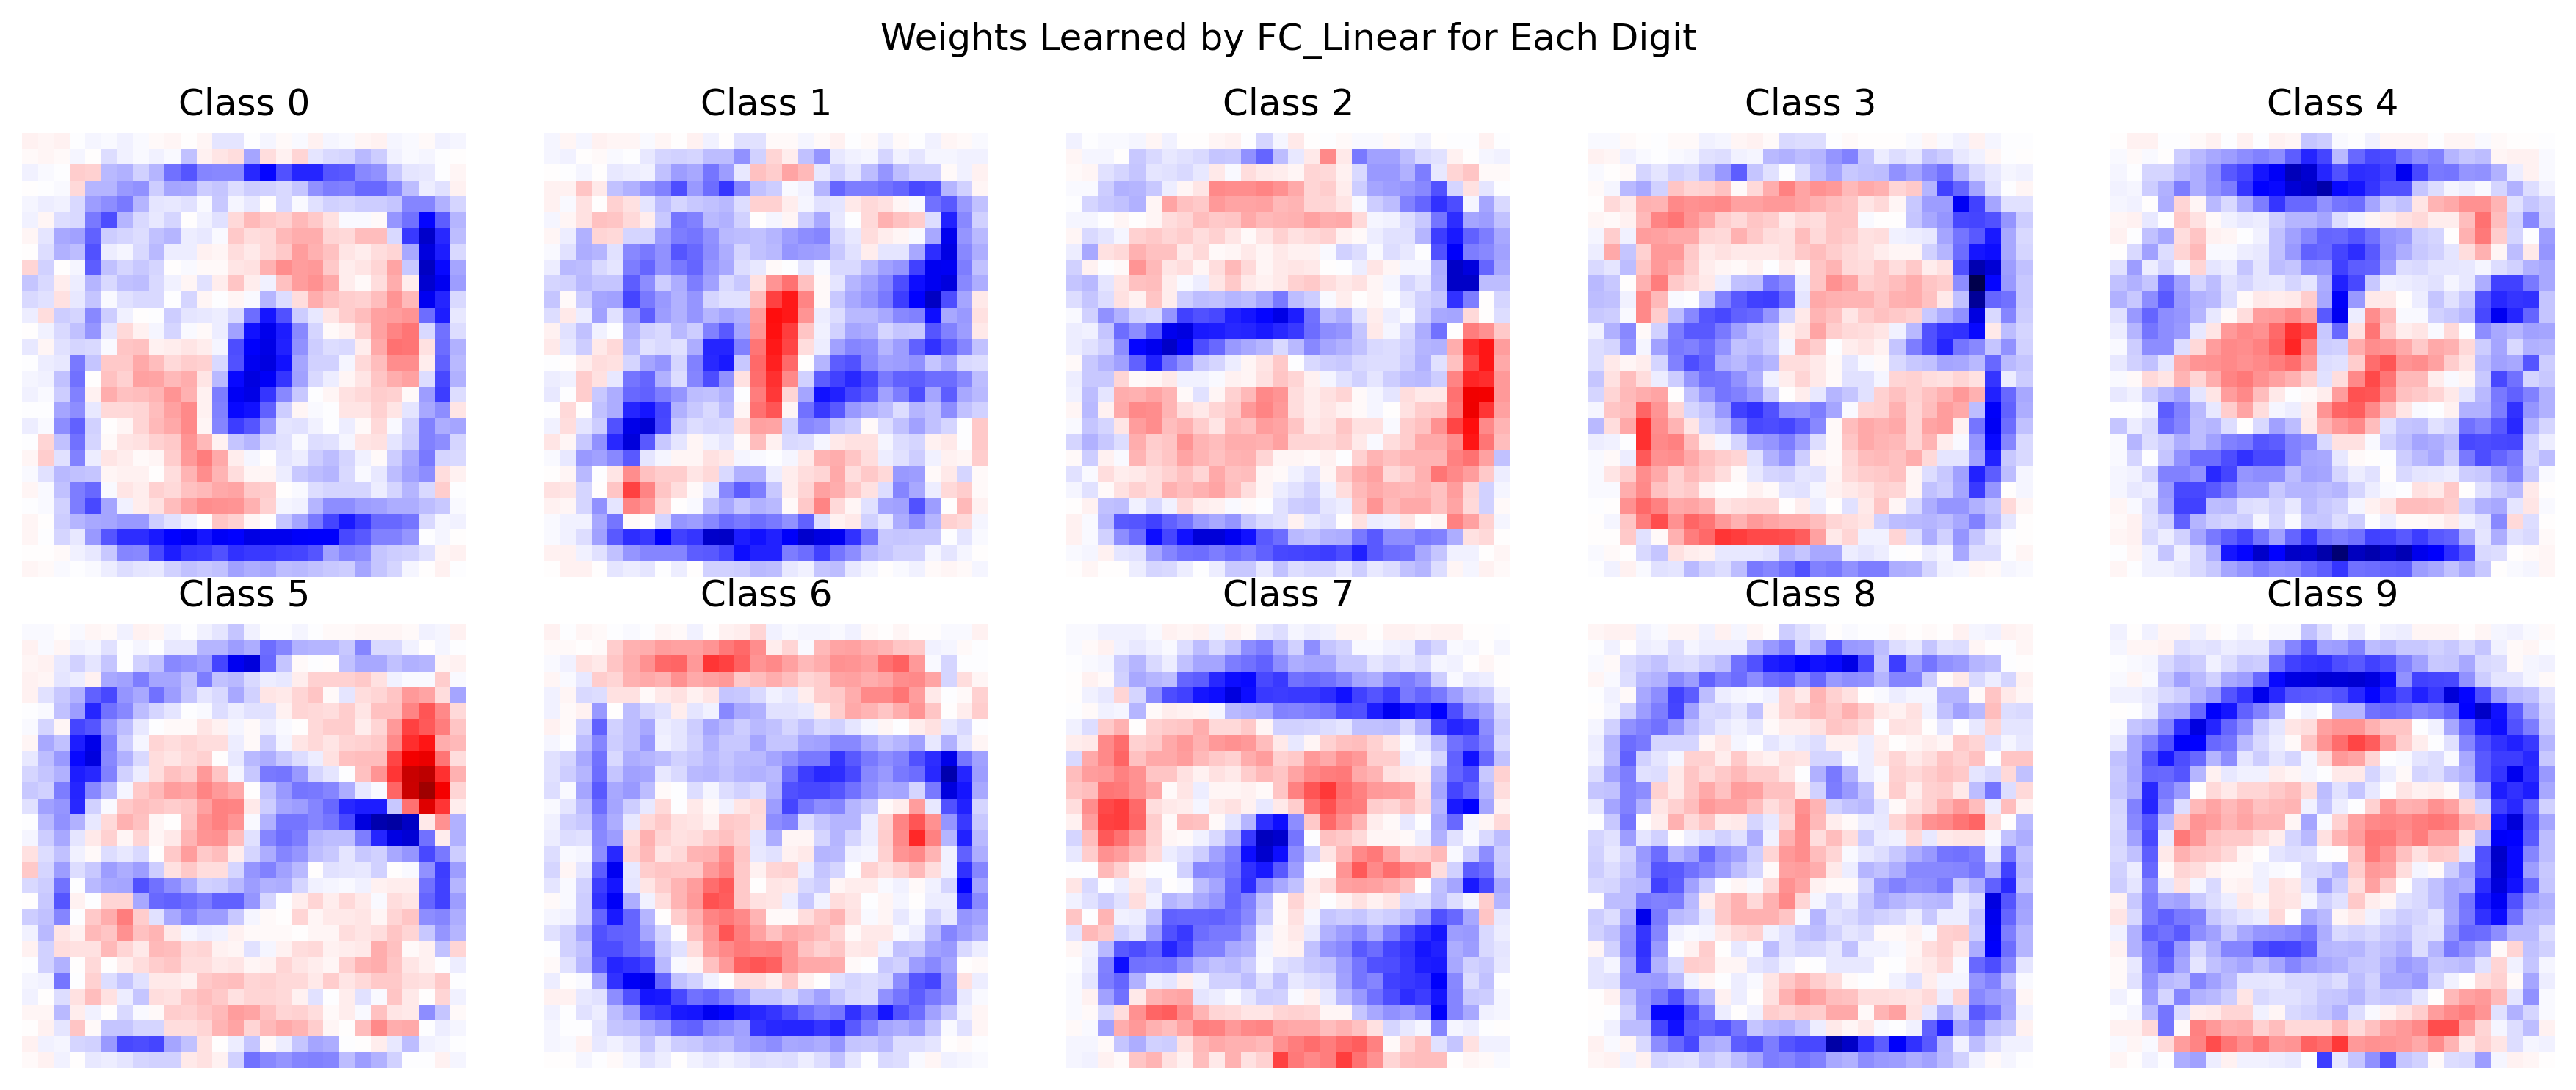

In [ ]:
weights = model.fc.weight.data.cpu() # 10 x 784

fig, axes = plt.subplots(2, 5, figsize=(12, 5), dpi=300)
for i in range(10):
    ax = axes[i // 5][i % 5]
    img = weights[i].reshape(28, 28)
    # seismic ensures red = positive, blue = negative, white = 0 for easy visualization.
    ax.imshow(img, cmap='seismic', vmin=-weights.abs().max(), vmax=weights.abs().max())
    ax.axis('off')
    ax.set_title(f"Class {i}")
plt.suptitle("Weights Learned by FC_Linear for Each Digit")
plt.tight_layout()
plt.show()

Observation: The learned weights is some average of training data.

## Base Performance

In [ ]:
def visualize_fc_linear_forward(model, image_tensor):
    """
    Visualize how a FC_Linear model views the input image.
    - Show the image
    - Show the weight heatmaps for each class (28x28)
    - Print output logits and prediction
    """
    model.eval()
    with torch.no_grad():
        x = image_tensor.view(1, -1).to(device)  # [1, 784]
        logits = model.fc(x).cpu().squeeze()     # [10]
        prediction = logits.argmax().item()

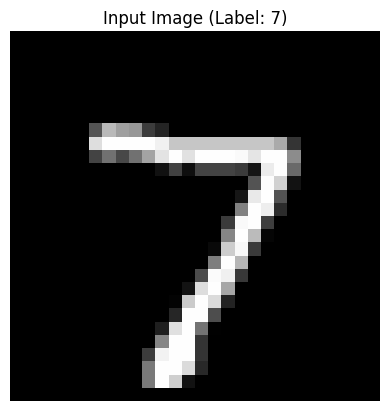

In [ ]:
# Show input
sample_img, sample_label = test_dataset[0]
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"Input Image (Label: {sample_label})")
plt.axis('off')
plt.show()

In [ ]:
predictions = model.forward(sample_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 7
Outputs: tensor([[ -2.8398, -12.9881,  -1.5849,   3.0915,  -5.0275,  -1.9177, -10.5510,
           8.3667,  -2.0067,   0.7807]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  prediction = model.forward(sample_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
base_performance = round(num_correct * 100 / test_size, 2)
total_learnable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

metrics['network_1'] = {
    'name': 'no hidden layers',
    'base_performance': base_performance,
    'total_learnable_parameters': total_learnable_parameters
}

In [ ]:
print(f"Base image dataset performance: {base_performance}%")
print(f"Total trainable parameters: {total_learnable_parameters:,}")

Base image dataset performance: 92.35%
Total trainable parameters: 7,850


## Shifting

In [ ]:
import torch.nn.functional as F

def shift_left(image_tensor, pixels):
    """
    Shift a single-channel image tensor left by `pixels`.

    Args:
        image_tensor (Tensor): shape [1, 28, 28] or [28, 28]
        pixels (int): number of pixels to shift left

    Returns:
        Tensor: shifted image of same shape
    """
    if image_tensor.ndim == 2:
        image_tensor = image_tensor.unsqueeze(0)  # [28, 28] → [1, 28, 28]

    assert image_tensor.shape[1:] == (28, 28), "Expected 28x28 image"

    # Pad right by `pixels`, then crop left
    padded = F.pad(image_tensor, pad=(0, pixels, 0, 0), mode='constant', value=0)  # (left, right, top, bottom)
    shifted = padded[:, :, pixels:]  # Remove `pixels` from left side

    return shifted.squeeze(0)  # return to [28, 28]

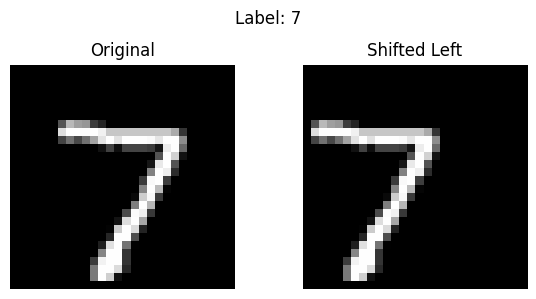

In [ ]:
import matplotlib.pyplot as plt

# Original image
sample_img, label = test_dataset[0]

# Shifted image
shifted_img = shift_left(sample_img, pixels=5)

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(sample_img.squeeze(), cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(shifted_img.squeeze(), cmap='gray')
axs[1].set_title("Shifted Left")
axs[1].axis('off')

plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.forward(shifted_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 3
Outputs: tensor([[ -7.5588,  -1.5711,  -1.1720,   2.2443, -11.3814,  -4.6128,  -7.8363,
          -0.3046,  -2.0232,  -4.5363]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


The model detected this image as a "3". This is an incorrect prediction, indicating the naive model cannot handle translation.

In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  shifted_img = shift_left(sample_img, pixels=5)
  prediction = model.forward(shifted_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
shifted_performance = round(num_correct * 100 / test_size, 2)
metrics['network_1']['shifted_performance'] = shifted_performance
print(f"Test shifted image dataset performance: {shifted_performance}%")

Test shifted image dataset performance: 16.01%


The low test performance is indicative that the model struggles to generalize even small translations.

## Rotation

In [ ]:
from torchvision.transforms import functional as TF

def rotate_image(image_tensor, degrees):
    """
    Rotates a single image tensor by given degrees.

    Args:
        image_tensor (Tensor): shape [1, 28, 28] or [28, 28]
        degrees (float): angle to rotate (positive = counterclockwise)

    Returns:
        Tensor: rotated image of same shape
    """
    if image_tensor.ndim == 2:
        image_tensor = image_tensor.unsqueeze(0)  # [28, 28] → [1, 28, 28]

    # Apply rotation (interpolation=nearest, expand=False keeps original shape)
    rotated = TF.rotate(image_tensor, angle=degrees, interpolation=TF.InterpolationMode.BILINEAR, expand=False, fill=0)

    return rotated.squeeze(0)  # return to [28, 28]

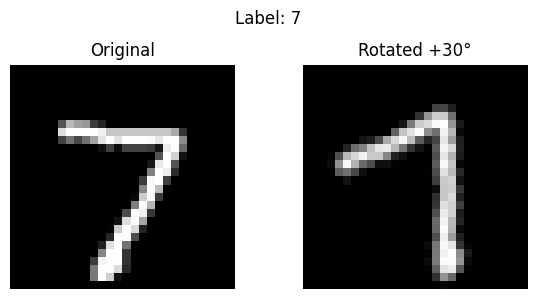

In [ ]:
# Original MNIST image
sample_img, label = test_dataset[0]

# Rotate it
rotated_img = rotate_image(sample_img, degrees=30)

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(sample_img.squeeze(), cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(rotated_img.squeeze(), cmap='gray')
axs[1].set_title("Rotated +30°")
axs[1].axis('off')

plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.forward(rotated_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 9
Outputs: tensor([[-4.3000, -8.4195, -4.9299, -1.0732, -3.7914,  0.1656, -8.6886,  4.2178,
         -0.5401,  5.1275]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  rotated_img = rotate_image(sample_img, degrees=30)
  prediction = model.forward(rotated_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
rotated_performance = round(num_correct * 100 / test_size, 2)
metrics['network_1']['rotated_performance'] = rotated_performance
print(f"Test rotated image dataset performance: {rotated_performance}%")

Test rotated image dataset performance: 55.29%


The model handles some degree of rotation better than translation.

## Scaling

In [ ]:
from torchvision.transforms import functional as TF

def scale_image(image_tensor, scale_factor):
    """
    Scales (zooms) an image tensor by the given scale factor.

    Args:
        image_tensor (Tensor): shape [1, 28, 28] or [28, 28]
        scale_factor (float): >1 = zoom in, <1 = zoom out

    Returns:
        Tensor: scaled image of shape [28, 28]
    """
    if image_tensor.ndim == 2:
        image_tensor = image_tensor.unsqueeze(0)  # [28, 28] → [1, 28, 28]

    orig_size = 28
    new_size = int(orig_size * scale_factor)

    # Resize image
    resized = TF.resize(image_tensor, [new_size, new_size], interpolation=TF.InterpolationMode.BILINEAR)

    # Center-crop or pad back to 28×28
    if scale_factor >= 1.0:
        # Zoom in → crop center
        scaled = TF.center_crop(resized, [orig_size, orig_size])
    else:
        # Zoom out → pad to center
        pad = (orig_size - new_size) // 2
        padding = [pad, pad, orig_size - new_size - pad, orig_size - new_size - pad]  # left, top, right, bottom
        scaled = TF.pad(resized, padding, fill=0)

    return scaled.squeeze(0)

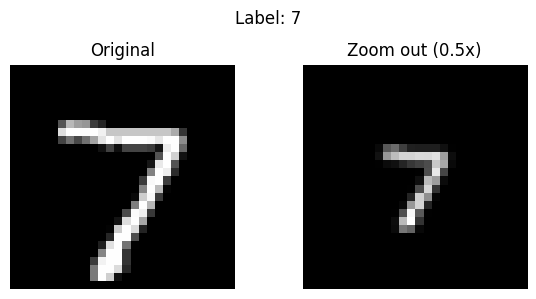

In [ ]:
# Sample image
sample_img, label = test_dataset[0]
zoomed_img = scale_image(sample_img, scale_factor=0.5)

# Plot original, zoom in, zoom out
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(sample_img.squeeze(), cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(zoomed_img.squeeze(), cmap='gray')
axs[1].set_title("Zoom out (0.5x)")
axs[1].axis('off')

plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.forward(zoomed_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 1
Outputs: tensor([[-5.9595,  3.2035, -2.4171, -1.7688,  1.6572, -0.8607, -0.1114,  1.4647,
         -0.4367,  0.3136]], device='cuda:0', grad_fn=<AddmmBackward0>)


Also makes incorrect prediction

In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  zoomed_img = scale_image(sample_img, scale_factor=0.5)
  prediction = model.forward(zoomed_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
scaled_performance = round(num_correct * 100 / test_size, 2)
metrics['network_1']['scaled_performance'] = scaled_performance
print(f"Test scaled image dataset performance: {scaled_performance}%")

Test scaled image dataset performance: 18.51%


The model struggles with scaling.

In [ ]:
metrics['network_1']

{'name': 'no hidden layers',
 'base_performance': 92.35,
 'total_learnable_parameters': 7850,
 'shifted_performance': 16.01,
 'rotated_performance': 55.29,
 'scaled_performance': 18.51}

# Network 2: FC network with single hidden layer

## Model Training

In [ ]:
class FC_Hidden(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model = train(FC_Hidden().to(device)) # Replace with model of interest

Epoch 1/5
  Train Loss: 0.2203, Train Acc: 93.70%
  Test  Loss: 0.2231, Test  Acc: 93.44%
Epoch 2/5
  Train Loss: 0.1593, Train Acc: 95.48%
  Test  Loss: 0.1632, Test  Acc: 95.21%
Epoch 3/5
  Train Loss: 0.1230, Train Acc: 96.46%
  Test  Loss: 0.1344, Test  Acc: 95.99%
Epoch 4/5
  Train Loss: 0.0969, Train Acc: 97.25%
  Test  Loss: 0.1160, Test  Acc: 96.67%
Epoch 5/5
  Train Loss: 0.0853, Train Acc: 97.56%
  Test  Loss: 0.1121, Test  Acc: 96.59%


## Visualization

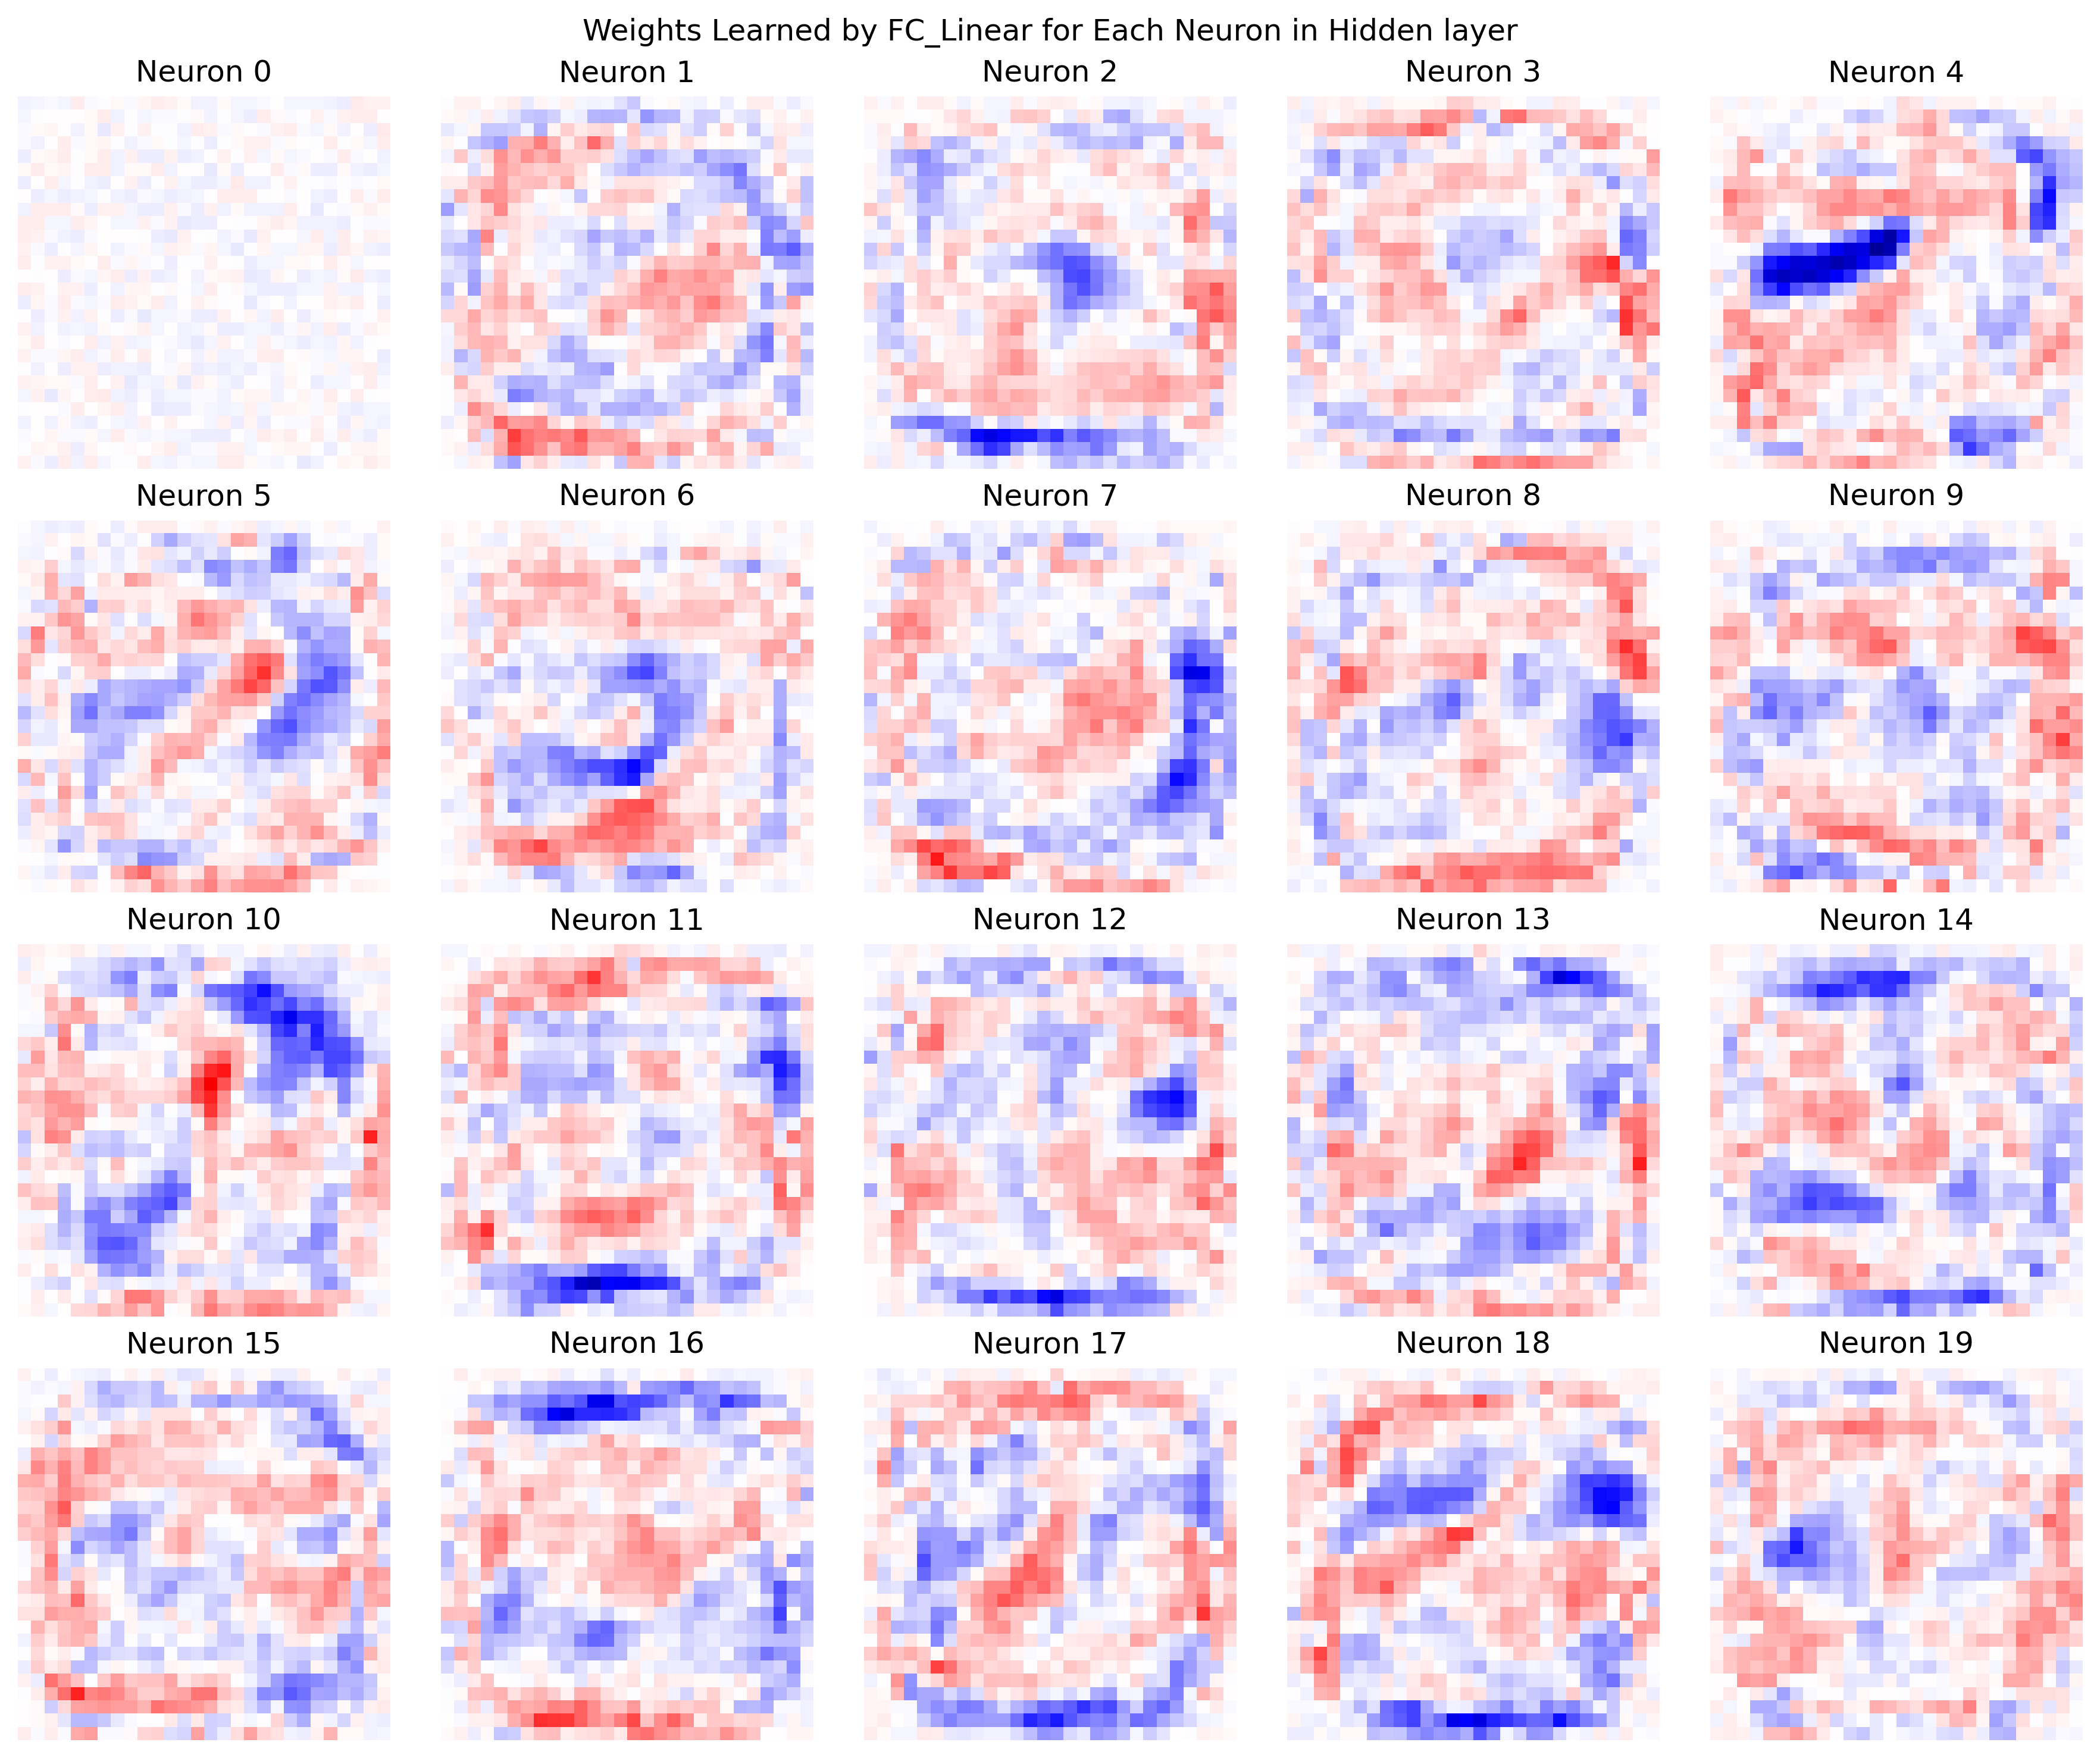

In [ ]:
weights = model.fc1.weight.data.cpu() # Visualize hidden layer weights

fig, axes = plt.subplots(4, 5, figsize=(12, 10), dpi=300)
for i in range(20): # Visualize just 20 of the hidden layer neurons.
    ax = axes[i // 5][i % 5]
    img = weights[i].reshape(28, 28)
    # seismic ensures red = positive, blue = negative, white = 0 for easy visualization.
    ax.imshow(img, cmap='seismic', vmin=-weights.abs().max(), vmax=weights.abs().max())
    ax.axis('off')
    ax.set_title(f"Neuron {i}")
plt.suptitle("Weights Learned by FC_Linear for Each Neuron in Hidden layer")
plt.tight_layout()
plt.show()

Observation: Each hidden neuron learns some parts of a digit.

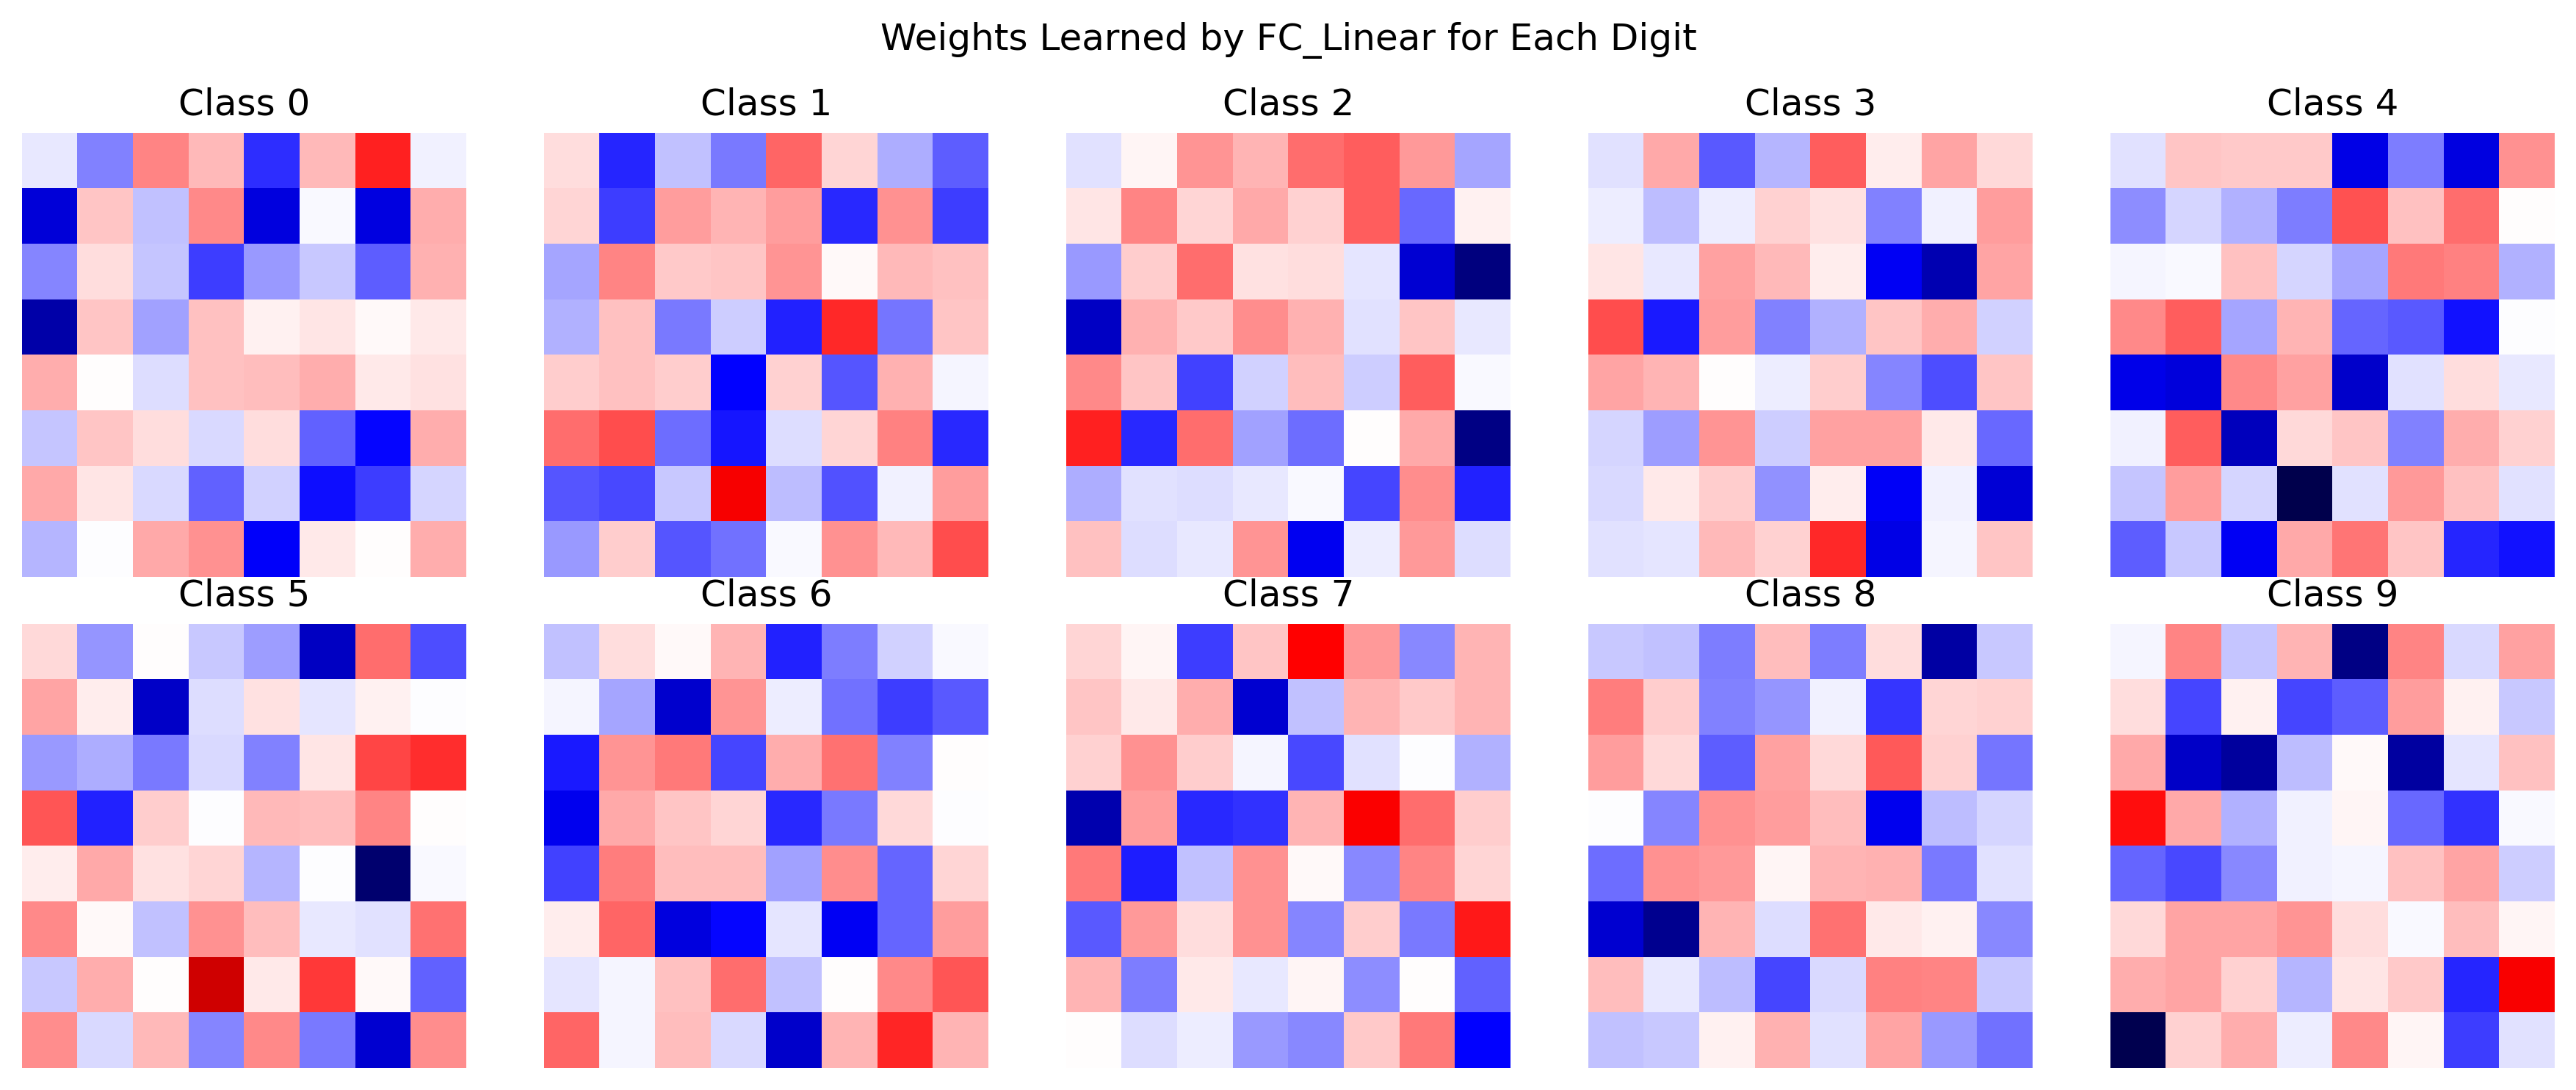

In [ ]:
weights = model.fc2.weight.data.cpu() # 10 x 64

fig, axes = plt.subplots(2, 5, figsize=(12, 5), dpi=300)
for i in range(10):
    ax = axes[i // 5][i % 5]
    img = weights[i].reshape(8, 8)
    # seismic ensures red = positive, blue = negative, white = 0 for easy visualization.
    ax.imshow(img, cmap='seismic', vmin=-weights.abs().max(), vmax=weights.abs().max())
    ax.axis('off')
    ax.set_title(f"Class {i}")
plt.suptitle("Weights Learned by FC_Linear for Each Digit")
plt.tight_layout()
plt.show()

## Base Performance

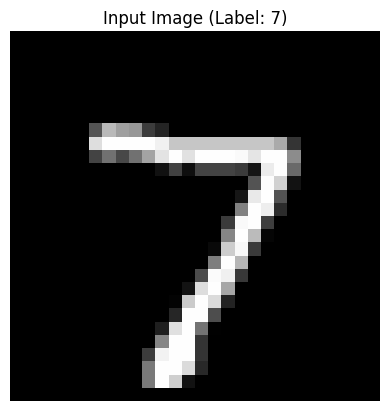

In [ ]:
# Show input
sample_img, sample_label = test_dataset[0]
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"Input Image (Label: {sample_label})")
plt.axis('off')
plt.show()

In [ ]:
predictions = model.forward(sample_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 7
Outputs: tensor([[ -1.6387, -10.6415,   1.5237,   2.7702, -11.0038,  -3.8877, -13.8024,
           9.4628,  -2.9755,  -2.9355]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


It predicts correctly on this data

In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  prediction = model.forward(sample_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
base_performance = round(num_correct * 100 / test_size, 2)
total_learnable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

metrics['network_2'] = {
    'name': '1 hidden layer',
    'base_performance': base_performance,
    'total_learnable_parameters': total_learnable_parameters
}

In [ ]:
print(f"Base image dataset performance: {base_performance}%")
print(f"Total trainable parameters: {total_learnable_parameters:,}")

Base image dataset performance: 96.59%
Total trainable parameters: 50,890


## Shifting

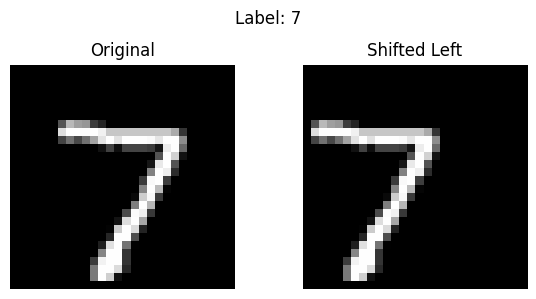

In [ ]:
import matplotlib.pyplot as plt

# Original image
sample_img, label = test_dataset[0]

# Shifted image
shifted_img = shift_left(sample_img, pixels=5)

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(sample_img.squeeze(), cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(shifted_img.squeeze(), cmap='gray')
axs[1].set_title("Shifted Left")
axs[1].axis('off')

plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.forward(shifted_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 7
Outputs: tensor([[ -5.2283,  -4.8918,  -0.3133,   3.4859,  -7.7211,  -6.5153, -10.6738,
           4.1831,   0.7628,  -3.8443]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


The prediction is correct this time, unlike the previous model

In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  shifted_img = shift_left(sample_img, pixels=5)
  prediction = model.forward(shifted_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
shifted_performance = round(num_correct * 100 / test_size, 2)
metrics['network_2']['shifted_performance'] = shifted_performance
print(f"Test shifted image dataset performance: {shifted_performance}%")

Test shifted image dataset performance: 26.79%


Though it is doing better than before, looks like the model still struggles with image translation.

## Rotation

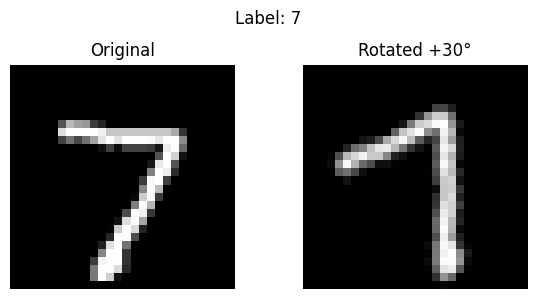

In [ ]:
# Original MNIST image
sample_img, label = test_dataset[0]

# Rotate it
rotated_img = rotate_image(sample_img, degrees=30)

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(sample_img.squeeze(), cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(rotated_img.squeeze(), cmap='gray')
axs[1].set_title("Rotated +30°")
axs[1].axis('off')

plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.forward(rotated_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 7
Outputs: tensor([[-3.1378, -7.2507, -2.3080, -0.8678, -8.9973, -0.5519, -8.4069,  4.2600,
         -1.6161,  2.2129]], device='cuda:0', grad_fn=<AddmmBackward0>)


The model predicts this correctly too.

In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  rotated_img = rotate_image(sample_img, degrees=30)
  prediction = model.forward(rotated_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
rotated_performance = round(num_correct * 100 / test_size, 2)
metrics['network_2']['rotated_performance'] = rotated_performance
print(f"Test rotated image dataset performance: {rotated_performance}%")

Test rotated image dataset performance: 69.45%


The model has a 91% performance on 15 deg rotation. And a 69% performance on 30 deg rotation.

## Scaling

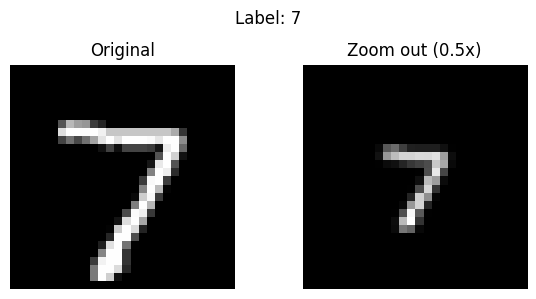

In [ ]:
# Sample image
sample_img, label = test_dataset[0]
zoomed_img = scale_image(sample_img, scale_factor=0.5)

# Plot original, zoom in, zoom out
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(sample_img.squeeze(), cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(zoomed_img.squeeze(), cmap='gray')
axs[1].set_title("Zoom out (0.5x)")
axs[1].axis('off')

plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.forward(zoomed_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 1
Outputs: tensor([[-4.2081,  1.1442, -1.2035, -4.2114,  0.6739, -4.0363, -2.2372,  0.6784,
         -1.8219, -2.1738]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  zoomed_img = scale_image(sample_img, scale_factor=0.5)
  prediction = model.forward(zoomed_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
scaled_performance = round(num_correct * 100 / test_size, 2)
metrics['network_2']['scaled_performance'] = scaled_performance
print(f"Test scaled image dataset performance: {scaled_performance}%")

Test scaled image dataset performance: 20.72%


Performance on scaling is not good.

In [ ]:
metrics['network_2']

{'name': '1 hidden layer',
 'base_performance': 96.59,
 'total_learnable_parameters': 50890,
 'shifted_performance': 26.79,
 'rotated_performance': 69.45,
 'scaled_performance': 20.72}

In [ ]:
metrics['network_1']

{'name': 'no hidden layers',
 'base_performance': 92.35,
 'total_learnable_parameters': 7850,
 'shifted_performance': 16.01,
 'rotated_performance': 55.29,
 'scaled_performance': 18.51}

# Network 3: 1 Convolution Layer Network

## Training

In [ ]:
class ConvOnly(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 8, kernel_size=5)  # [28x28] → [24x24]
        self.fc = nn.Linear(8 * 24 * 24, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 8 * 24 * 24)
        return self.fc(x)

model = train(ConvOnly().to(device)) # Replace with model of interest

Epoch 1/5
  Train Loss: 0.2944, Train Acc: 91.63%
  Test  Loss: 0.2960, Test  Acc: 91.46%
Epoch 2/5
  Train Loss: 0.2768, Train Acc: 92.25%
  Test  Loss: 0.2907, Test  Acc: 91.74%
Epoch 3/5
  Train Loss: 0.2699, Train Acc: 92.41%
  Test  Loss: 0.2799, Test  Acc: 91.94%
Epoch 4/5
  Train Loss: 0.2618, Train Acc: 92.77%
  Test  Loss: 0.2757, Test  Acc: 92.18%
Epoch 5/5
  Train Loss: 0.2680, Train Acc: 92.51%
  Test  Loss: 0.2925, Test  Acc: 91.93%


## Visualization

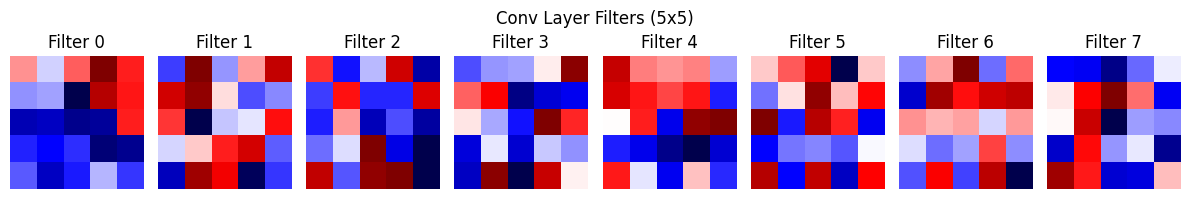

In [ ]:
filters = model.conv.weight.data.cpu()  # shape: [8, 1, 5, 5]
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    axes[i].imshow(filters[i, 0], cmap='seismic')
    axes[i].axis('off')
    axes[i].set_title(f'Filter {i}')
plt.suptitle("Conv Layer Filters (5x5)")
plt.tight_layout()
plt.show()

Ticky to understand what is learned. It's easier to visualize with an example

In [ ]:
def visualize_feature_maps(model, image_tensor):
    model.eval()
    with torch.no_grad():
        x = image_tensor.unsqueeze(0).to(next(model.parameters()).device)  # [1, 1, 28, 28]
        activations = model.conv(x).cpu().squeeze(0)  # [8, 24, 24]

    fig, axes = plt.subplots(1, 8, figsize=(12, 2))
    for i in range(8):
        axes[i].imshow(activations[i], cmap='seismic')
        axes[i].axis('off')
        axes[i].set_title(f'Feature map {i}')
    plt.suptitle("Conv Layer Activations")
    plt.tight_layout()
    plt.show()

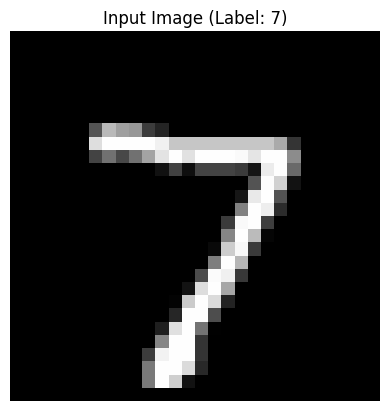

In [ ]:
# Show input
sample_img, sample_label = test_dataset[0]
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"Input Image (Label: {sample_label})")
plt.axis('off')
plt.show()

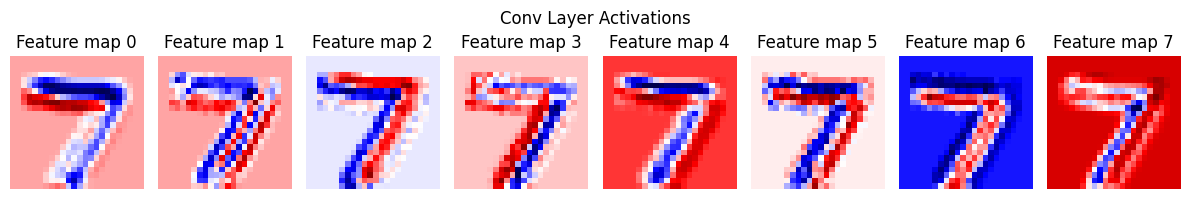

In [ ]:
visualize_feature_maps(model, sample_img)

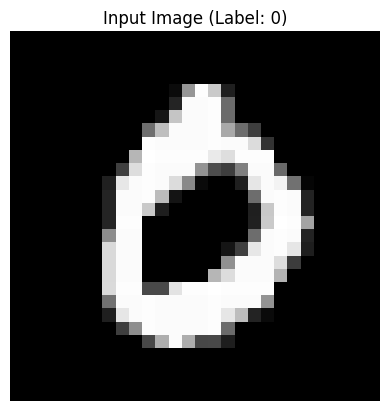

In [ ]:
# Show input
sample_img, sample_label = test_dataset[3]
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"Input Image (Label: {sample_label})")
plt.axis('off')
plt.show()

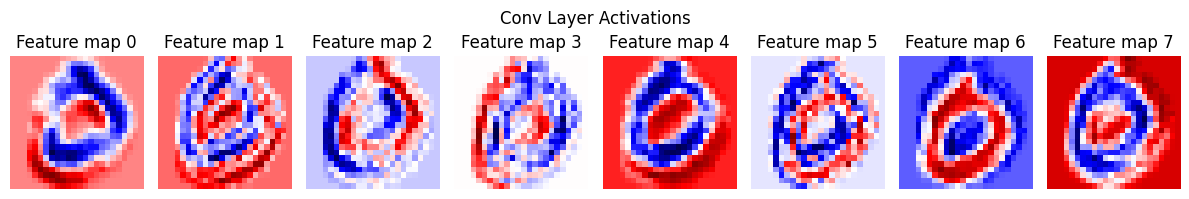

In [ ]:
visualize_feature_maps(model, sample_img)

The outputs are when each filter is convolved on the input image. Each case highlights a feature that is detected in the image and will be passed to later layers.

## Base Performance

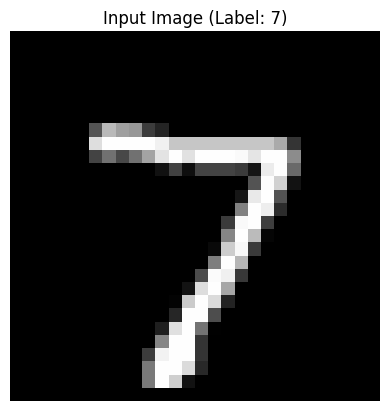

In [ ]:
# Show input
sample_img, sample_label = test_dataset[0]
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"Input Image (Label: {sample_label})")
plt.axis('off')
plt.show()

In [ ]:
predictions = model.forward(sample_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 7
Outputs: tensor([[ -0.4090, -13.3809,  -0.9050,   5.7243,  -4.1824,  -0.5954, -11.8181,
          11.5077,  -0.4524,   2.6219]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  prediction = model.forward(sample_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
base_performance = round(num_correct * 100 / test_size, 2)
total_learnable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

metrics['network_3'] = {
    'name': '1 Conv layer',
    'base_performance': base_performance,
    'total_learnable_parameters': total_learnable_parameters
}

In [ ]:
print(f"Base image dataset performance: {base_performance}%")
print(f"Total trainable parameters: {total_learnable_parameters:,}")

Base image dataset performance: 91.93%
Total trainable parameters: 46,298


This performance is worse than the FC linear hidden layer (with relu activation). Likely because the model is restricted to linear units and the number of parameters decreased. This decreases the expressive power of the model

## Shifting

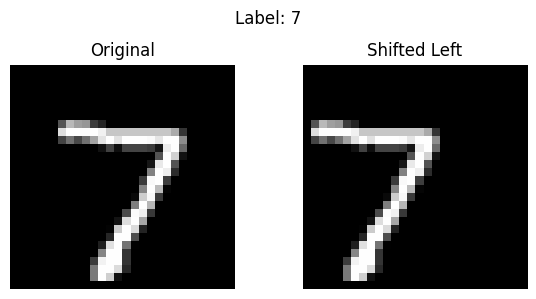

In [ ]:
import matplotlib.pyplot as plt

# Original image
sample_img, label = test_dataset[0]

# Shifted image
shifted_img = shift_left(sample_img, pixels=5)

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(sample_img.squeeze(), cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(shifted_img.squeeze(), cmap='gray')
axs[1].set_title("Shifted Left")
axs[1].axis('off')

plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.forward(shifted_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 3
Outputs: tensor([[-4.3181,  2.4612,  0.3699,  4.7074, -8.8259, -3.5540, -4.1813,  2.5581,
          1.9790, -1.5225]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  shifted_img = shift_left(sample_img, pixels=5)
  prediction = model.forward(shifted_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
shifted_performance = round(num_correct * 100 / test_size, 2)
metrics['network_3']['shifted_performance'] = shifted_performance
print(f"Test shifted image dataset performance: {shifted_performance}%")

Test shifted image dataset performance: 14.26%


## Rotation

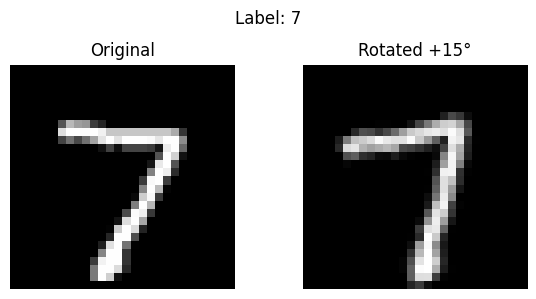

In [ ]:
# Original MNIST image
sample_img, label = test_dataset[0]

# Rotate it
rotated_img = rotate_image(sample_img, degrees=15)

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(sample_img.squeeze(), cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(rotated_img.squeeze(), cmap='gray')
axs[1].set_title("Rotated +15°")
axs[1].axis('off')

plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.forward(rotated_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 7
Outputs: tensor([[ -1.5700, -11.6871,  -1.7606,   3.8270,  -4.9197,   0.4716, -11.9219,
          10.4699,   0.4920,   5.2213]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  rotated_img = rotate_image(sample_img, degrees=30)
  prediction = model.forward(rotated_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
rotated_performance = round(num_correct * 100 / test_size, 2)
metrics['network_3']['rotated_performance'] = rotated_performance
print(f"Test rotated image dataset performance: {rotated_performance}%")

Test rotated image dataset performance: 54.49%


## Scaling

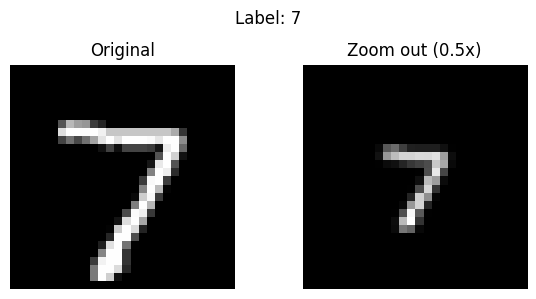

In [ ]:
# Sample image
sample_img, label = test_dataset[0]
zoomed_img = scale_image(sample_img, scale_factor=0.5)

# Plot original, zoom in, zoom out
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(sample_img.squeeze(), cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(zoomed_img.squeeze(), cmap='gray')
axs[1].set_title("Zoom out (0.5x)")
axs[1].axis('off')

plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.forward(zoomed_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 1
Outputs: tensor([[-7.6687,  5.0565, -2.3728, -1.2174,  2.6492,  0.6631,  0.7992,  3.3481,
         -0.7126,  1.2742]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  zoomed_img = scale_image(sample_img, scale_factor=0.5)
  prediction = model.forward(zoomed_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
scaled_performance = round(num_correct * 100 / test_size, 2)
metrics['network_3']['scaled_performance'] = scaled_performance
print(f"Test scaled image dataset performance: {scaled_performance}%")

Test scaled image dataset performance: 17.95%


In [ ]:
metrics['network_3']

{'name': '1 Conv layer',
 'base_performance': 91.93,
 'total_learnable_parameters': 46298,
 'shifted_performance': 14.26,
 'rotated_performance': 54.49,
 'scaled_performance': 17.95}

In [ ]:
metrics['network_2']

{'name': '1 hidden layer',
 'base_performance': 96.59,
 'total_learnable_parameters': 50890,
 'shifted_performance': 26.79,
 'rotated_performance': 69.45,
 'scaled_performance': 20.72}

# Network 4: 1 Convolution + Activation Network

## Model Training

In [ ]:
class ConvAct(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 8, kernel_size=5)  # [28x28] → [24x24]
        self.fc = nn.Linear(8 * 24 * 24, 10)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = x.view(-1, 8 * 24 * 24)
        return self.fc(x)

model = train(ConvAct().to(device)) # Replace with model of interest

Epoch 1/5
  Train Loss: 0.1113, Train Acc: 96.86%
  Test  Loss: 0.1079, Test  Acc: 97.09%
Epoch 2/5
  Train Loss: 0.0772, Train Acc: 97.75%
  Test  Loss: 0.0800, Test  Acc: 97.61%
Epoch 3/5
  Train Loss: 0.0546, Train Acc: 98.45%
  Test  Loss: 0.0664, Test  Acc: 97.85%
Epoch 4/5
  Train Loss: 0.0489, Train Acc: 98.55%
  Test  Loss: 0.0624, Test  Acc: 98.07%
Epoch 5/5
  Train Loss: 0.0378, Train Acc: 98.91%
  Test  Loss: 0.0605, Test  Acc: 98.15%


## Visualization

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def visualize_feature_maps(model, image_tensor):
    """
    Shows, for each of the 8 filters:
      • the raw convolution output (can be negative or positive)
      • the ReLU-activated output (non-negative)
    """
    model.eval()
    with torch.no_grad():
        x = image_tensor.unsqueeze(0).to(next(model.parameters()).device)  # [1, 1, 28, 28]
        conv_out  = model.conv(x)               # pre-activation  → [1, 8, 24, 24]
        relu_out  = F.relu(conv_out)            # post-activation → [1, 8, 24, 24]

        conv_out = conv_out.cpu().squeeze(0)    # [8, 24, 24]
        relu_out = relu_out.cpu().squeeze(0)    # [8, 24, 24]

    # Use the same global scale so colours are comparable
    vmax = conv_out.abs().max().item()

    fig, axes = plt.subplots(2, 8, figsize=(16, 4), dpi=150)
    for i in range(8):
        # Row 0 – raw conv output
        axes[0, i].imshow(conv_out[i], cmap='seismic',
                          vmin=-vmax, vmax=vmax)
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Filter {i}')

        # Row 1 – after ReLU
        axes[1, i].imshow(relu_out[i], cmap='seismic',
                          vmin=-vmax, vmax=vmax)
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel('Pre-ReLU', fontsize=12)
    axes[1, 0].set_ylabel('Post-ReLU', fontsize=12)
    plt.suptitle("Conv Layer Activations (raw vs. ReLU)", fontsize=14)
    plt.tight_layout()
    plt.show()

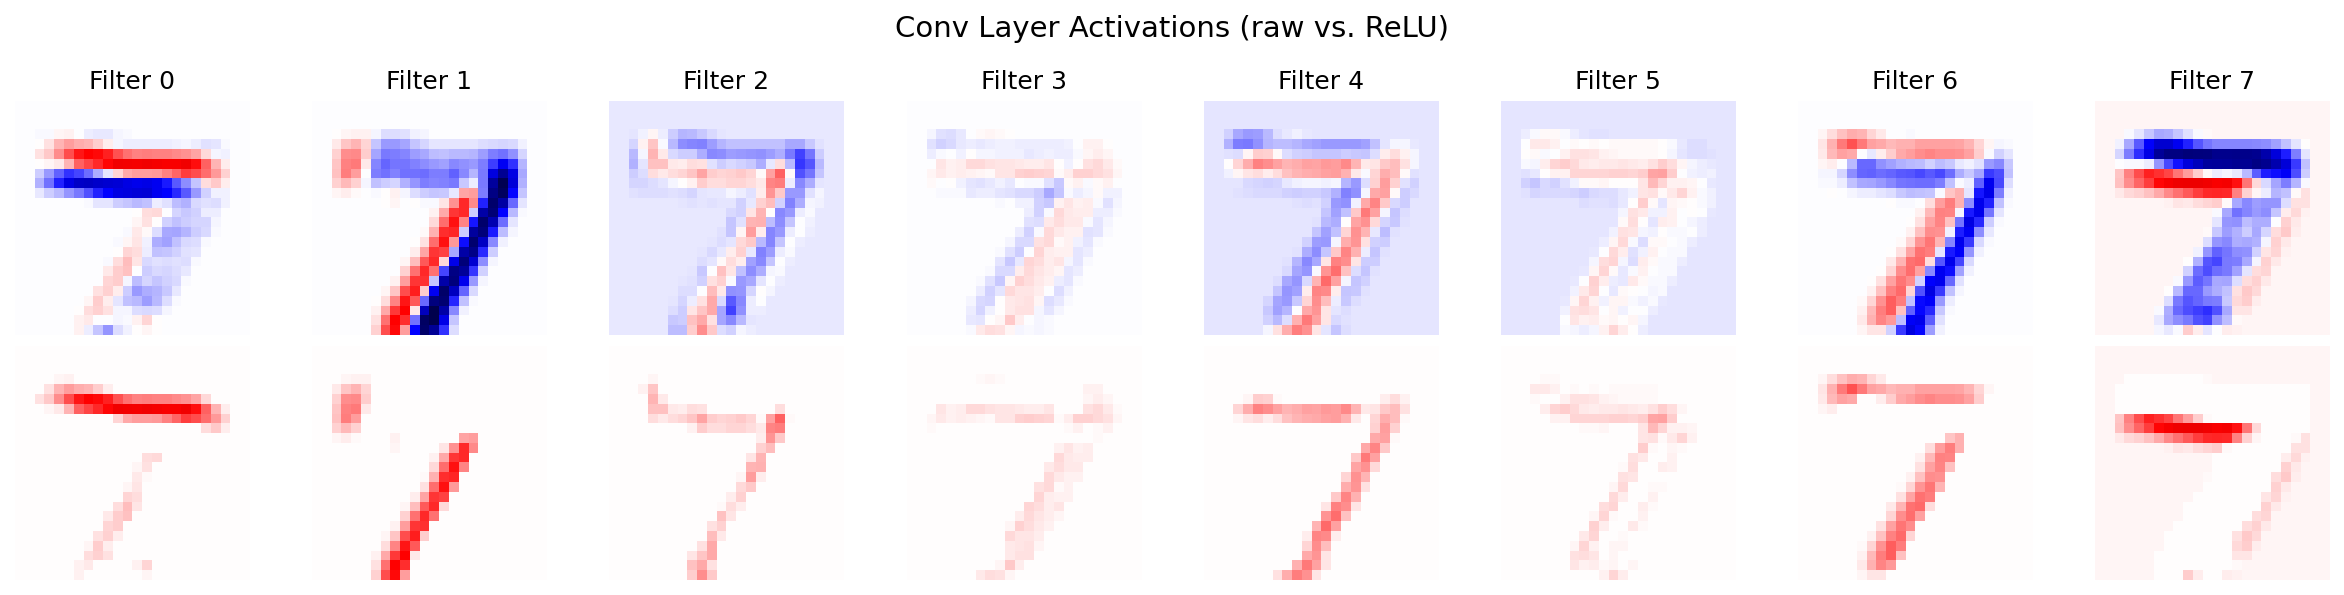

In [ ]:
sample_img, label = test_dataset[0]
visualize_feature_maps(model, sample_img)

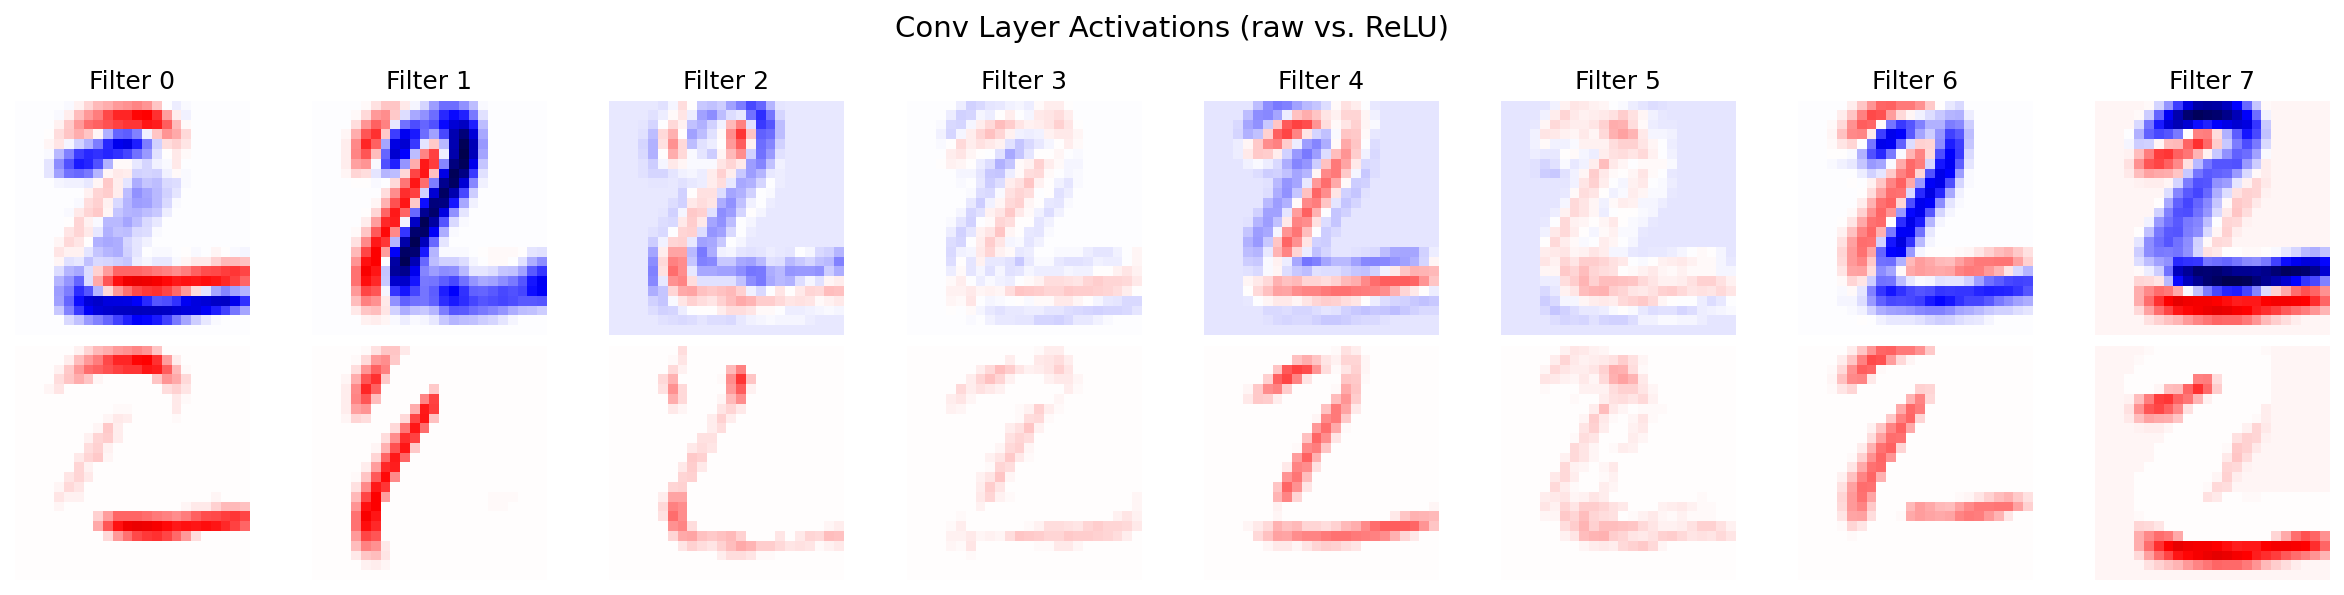

In [ ]:
sample_img, label = test_dataset[1]
visualize_feature_maps(model, sample_img)

## Base Performance

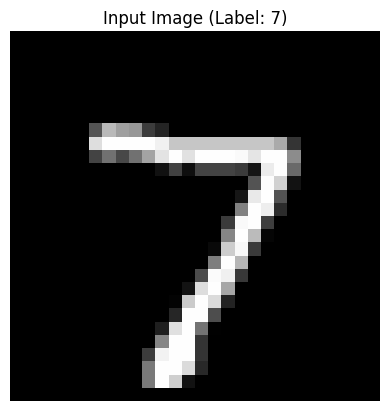

In [ ]:
# Show input
sample_img, sample_label = test_dataset[0]
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"Input Image (Label: {sample_label})")
plt.axis('off')
plt.show()

In [ ]:
predictions = model.forward(sample_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 7
Outputs: tensor([[ -9.0306,  -9.8948,  -3.8252,  -1.6245,  -9.3511,  -7.3916, -19.8722,
          11.6610,  -7.0436,  -0.9873]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  prediction = model.forward(sample_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
base_performance = round(num_correct * 100 / test_size, 2)
total_learnable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

metrics['network_4'] = {
    'name': '1 Conv + Activation layer',
    'base_performance': base_performance,
    'total_learnable_parameters': total_learnable_parameters
}

In [ ]:
print(f"Base image dataset performance: {base_performance}%")
print(f"Total trainable parameters: {total_learnable_parameters:,}")

Base image dataset performance: 97.67%
Total trainable parameters: 46,298


## Shifting

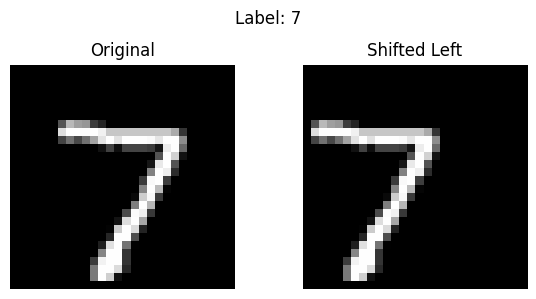

In [ ]:
import matplotlib.pyplot as plt

# Original image
sample_img, label = test_dataset[0]

# Shifted image
shifted_img = shift_left(sample_img, pixels=5)

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(sample_img.squeeze(), cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(shifted_img.squeeze(), cmap='gray')
axs[1].set_title("Shifted Left")
axs[1].axis('off')

plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.forward(shifted_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 7
Outputs: tensor([[ -5.9553,   1.8587,   3.9980,  -6.4043, -13.8909, -16.3166, -19.4797,
          11.3188, -10.0790, -12.0519]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  shifted_img = shift_left(sample_img, pixels=5)
  prediction = model.forward(shifted_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
shifted_performance = round(num_correct * 100 / test_size, 2)
metrics['network_4']['shifted_performance'] = shifted_performance
print(f"Test shifted image dataset performance: {shifted_performance}%")

Test shifted image dataset performance: 40.6%


## Rotation

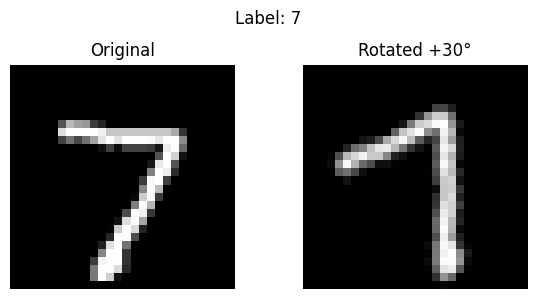

In [ ]:
# Original MNIST image
sample_img, label = test_dataset[0]

# Rotate it
rotated_img = rotate_image(sample_img, degrees=30)

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(sample_img.squeeze(), cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(rotated_img.squeeze(), cmap='gray')
axs[1].set_title("Rotated +30°")
axs[1].axis('off')

plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.forward(rotated_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 7
Outputs: tensor([[-10.1834,  -6.1634,  -2.3800,  -1.2319,  -2.9332,  -6.5523, -20.4668,
           5.0184,  -6.7598,   4.8000]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  rotated_img = rotate_image(sample_img, degrees=30)
  prediction = model.forward(rotated_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
rotated_performance = round(num_correct * 100 / test_size, 2)
metrics['network_4']['rotated_performance'] = rotated_performance
print(f"Test rotated image dataset performance: {rotated_performance}%")

Test rotated image dataset performance: 77.32%


## Scaling

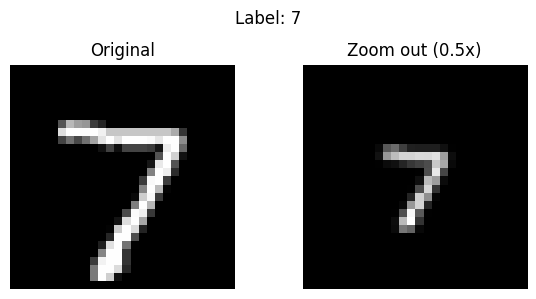

In [ ]:
# Sample image
sample_img, label = test_dataset[0]
zoomed_img = scale_image(sample_img, scale_factor=0.5)

# Plot original, zoom in, zoom out
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(sample_img.squeeze(), cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(zoomed_img.squeeze(), cmap='gray')
axs[1].set_title("Zoom out (0.5x)")
axs[1].axis('off')

plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.forward(zoomed_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 9
Outputs: tensor([[-4.7693, -0.8675, -1.2703, -5.6639, -4.2253, -3.0061, -6.5048, -0.4770,
         -1.4130, -0.3365]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  zoomed_img = scale_image(sample_img, scale_factor=0.5)
  prediction = model.forward(zoomed_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
scaled_performance = round(num_correct * 100 / test_size, 2)
metrics['network_4']['scaled_performance'] = scaled_performance
print(f"Test scaled image dataset performance: {scaled_performance}%")

Test scaled image dataset performance: 32.44%


In [ ]:
metrics['network_4']

{'name': '1 Conv + Activation layer',
 'base_performance': 97.67,
 'total_learnable_parameters': 46298,
 'shifted_performance': 40.6,
 'rotated_performance': 77.32,
 'scaled_performance': 32.44}

In [ ]:
metrics['network_3']

{'name': '1 Conv layer',
 'base_performance': 91.93,
 'total_learnable_parameters': 46298,
 'shifted_performance': 14.26,
 'rotated_performance': 54.49,
 'scaled_performance': 17.95}

This improvement in performance over network 3 shows the power of non-linear activation functions.

# Network 5: 1 Convolution + Activation + Pooling Network

## Model Training

In [ ]:
class ConvActPool(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 8, kernel_size=5)  # [28x28] → [24x24]
        self.pool = nn.MaxPool2d(2, 2)              # [24x24] → [12x12]
        self.fc = nn.Linear(8 * 12 * 12, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = x.view(-1, 8 * 12 * 12)
        return self.fc(x)

model = train(ConvActPool().to(device)) # Replace with model of interest

Epoch 1/5
  Train Loss: 0.1616, Train Acc: 95.47%
  Test  Loss: 0.1521, Test  Acc: 95.58%
Epoch 2/5
  Train Loss: 0.0998, Train Acc: 97.18%
  Test  Loss: 0.0931, Test  Acc: 97.17%
Epoch 3/5
  Train Loss: 0.0720, Train Acc: 97.97%
  Test  Loss: 0.0702, Test  Acc: 97.85%
Epoch 4/5
  Train Loss: 0.0585, Train Acc: 98.33%
  Test  Loss: 0.0603, Test  Acc: 98.05%
Epoch 5/5
  Train Loss: 0.0528, Train Acc: 98.48%
  Test  Loss: 0.0579, Test  Acc: 98.10%


## Visualization

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torch.nn.functional as F
import matplotlib.pyplot as plt

def visualize_feature_maps(model, image_tensor):
    """
    Visualize, for a ConvActPool network, the progression:
        conv  →  ReLU  →  max-pool
    """
    model.eval()
    with torch.no_grad():
        x = image_tensor.unsqueeze(0).to(next(model.parameters()).device)  # [1,1,28,28]

        # --- forward pass up to pooling ---
        conv_out = model.conv(x)           # [1, 8, 24, 24]
        relu_out = F.relu(conv_out)        # [1, 8, 24, 24]
        pool_out = model.pool(relu_out)    # [1, 8, 12, 12]

        conv_out = conv_out.cpu().squeeze(0)   # [8, 24, 24]
        relu_out = relu_out.cpu().squeeze(0)   # [8, 24, 24]
        pool_out = pool_out.cpu().squeeze(0)   # [8, 12, 12]

    # Common colour scale so maps are comparable
    vmax = conv_out.abs().max().item()

    fig, axes = plt.subplots(3, 8, figsize=(16, 6), dpi=150)
    for i in range(8):
        # Row 0 – raw conv
        axes[0, i].imshow(conv_out[i], cmap='seismic',
                          vmin=-vmax, vmax=vmax, interpolation='nearest')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Filter {i}')

        # Row 1 – after ReLU
        axes[1, i].imshow(relu_out[i], cmap='seismic',
                          vmin=-vmax, vmax=vmax, interpolation='nearest')
        axes[1, i].axis('off')

        # Row 2 – after MaxPool (12×12)
        axes[2, i].imshow(pool_out[i], cmap='seismic',
                          vmin=-vmax, vmax=vmax, interpolation='nearest')
        axes[2, i].axis('off')

    axes[0, 0].set_ylabel('Conv',     fontsize=11)
    axes[1, 0].set_ylabel('ReLU',     fontsize=11)
    axes[2, 0].set_ylabel('MaxPool',  fontsize=11)

    plt.suptitle("Feature-map Progression: Conv → ReLU → Pool", fontsize=14)
    plt.tight_layout()
    plt.show()

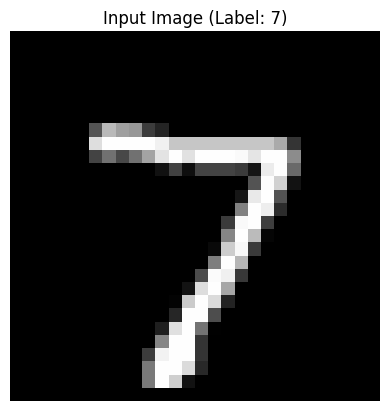

In [ ]:
# Show input
sample_img, sample_label = test_dataset[0]
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"Input Image (Label: {sample_label})")
plt.axis('off')
plt.show()

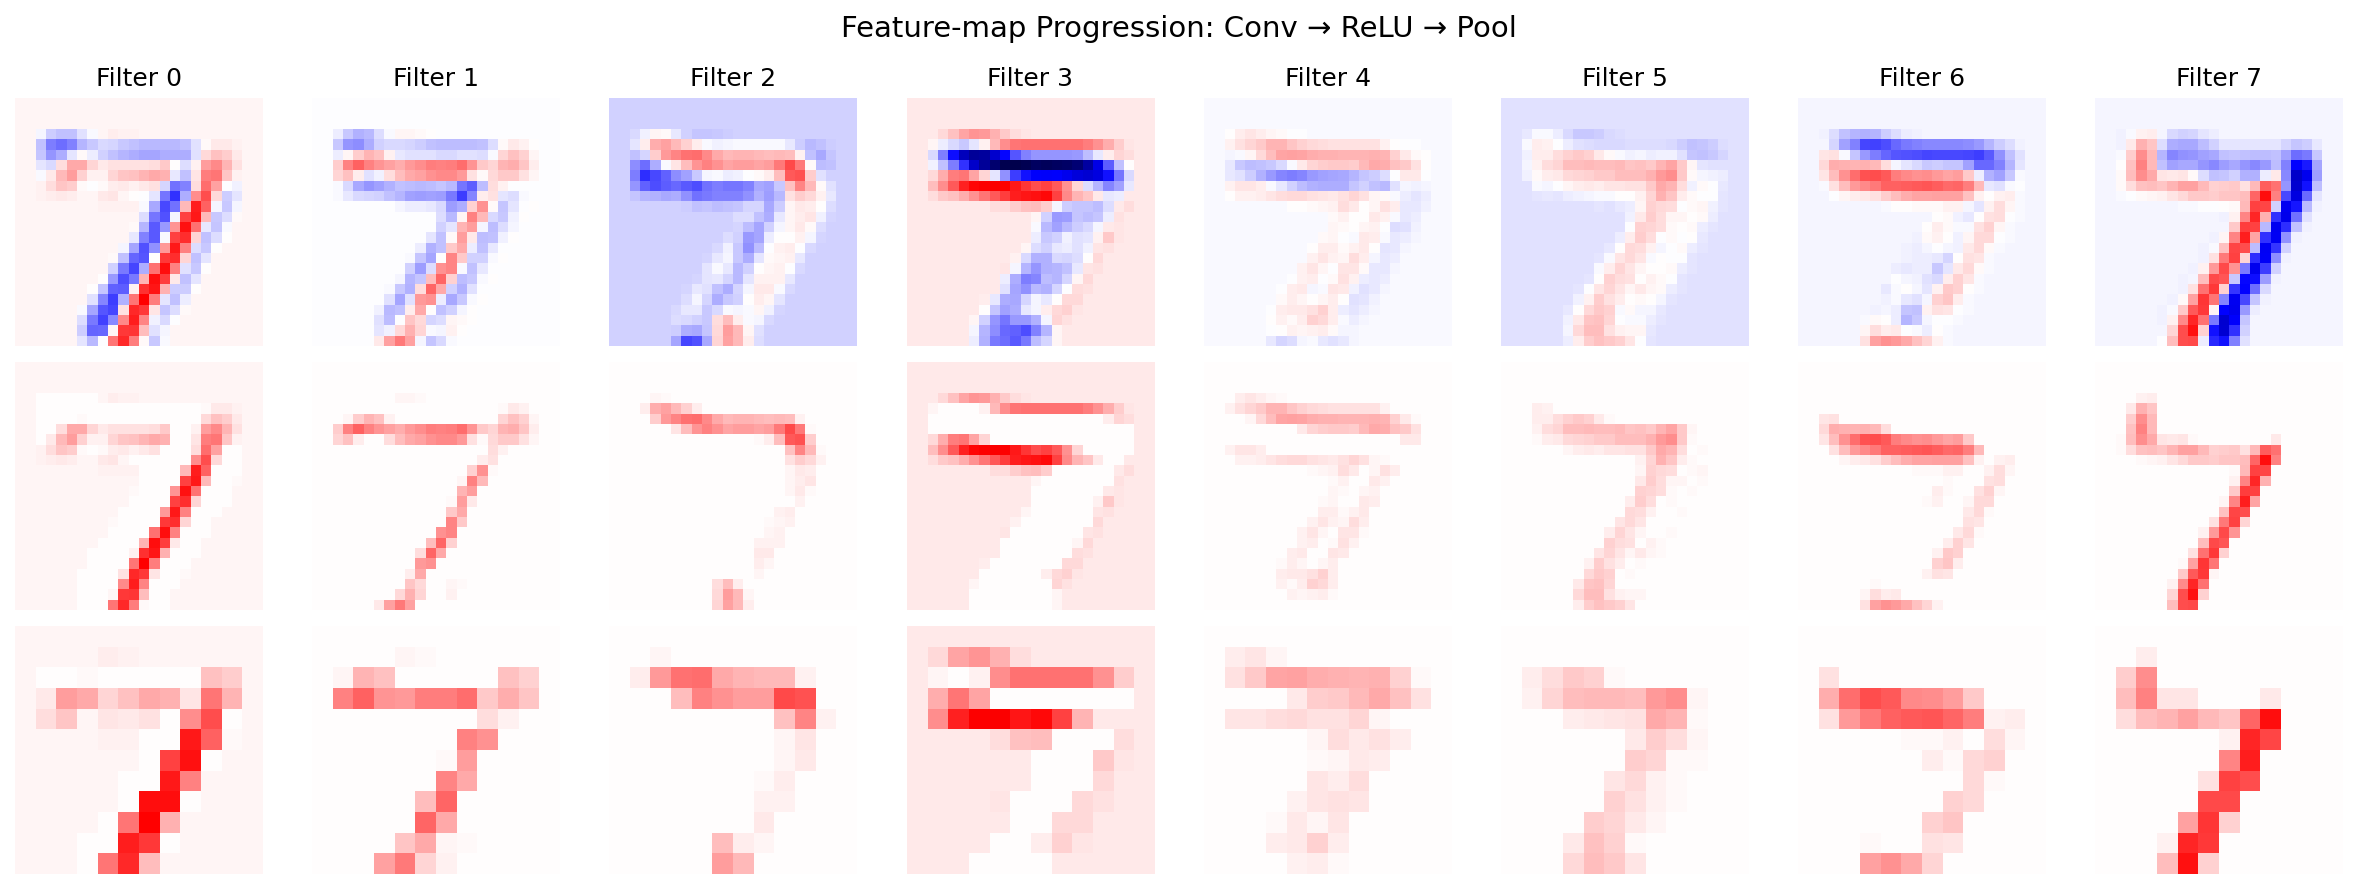

In [ ]:
sample_img, label = test_dataset[0]
visualize_feature_maps(model, sample_img)

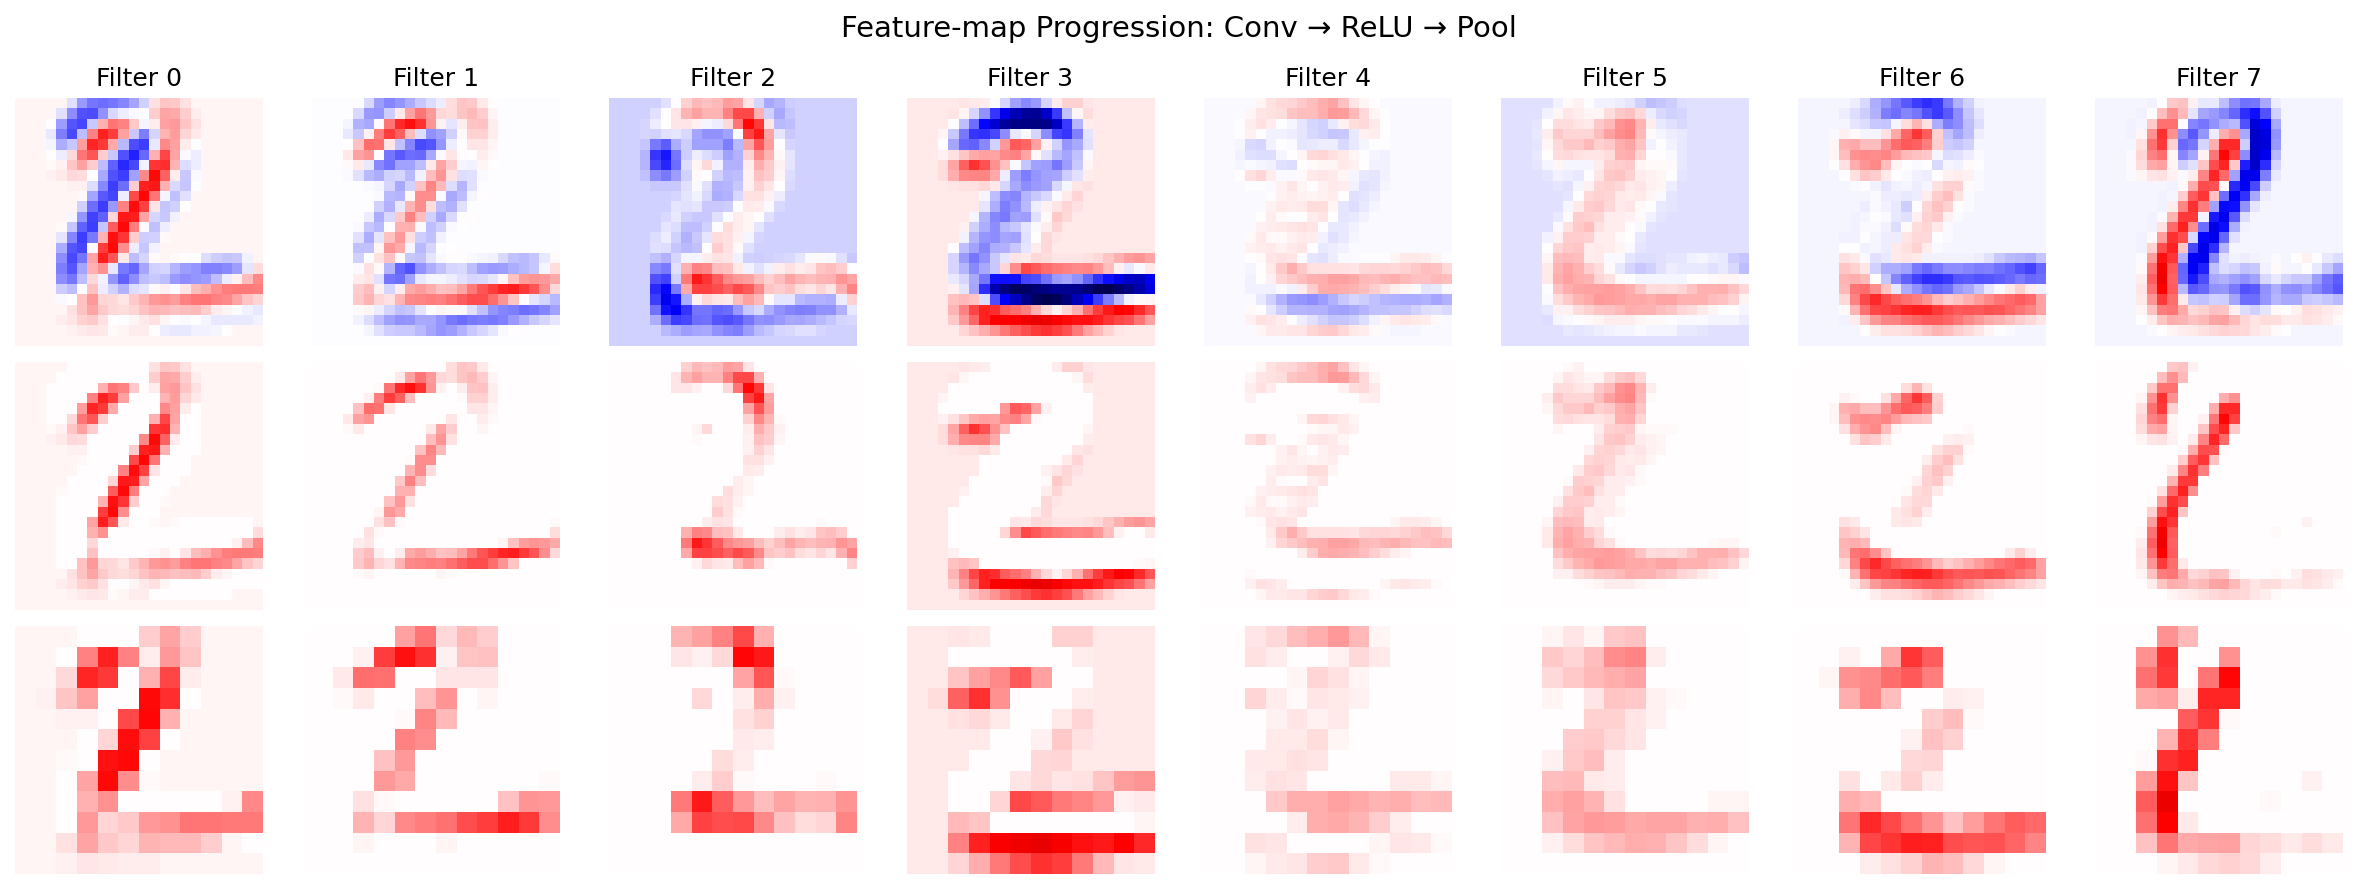

In [ ]:
sample_img, label = test_dataset[1]
visualize_feature_maps(model, sample_img)

## Base Performance

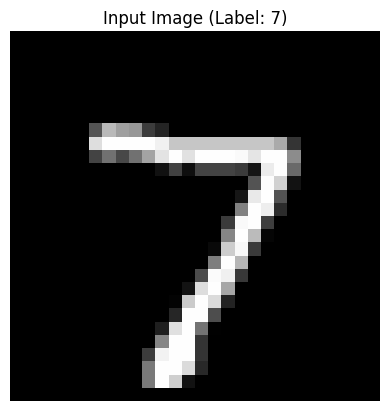

In [ ]:
# Show input
sample_img, sample_label = test_dataset[0]
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"Input Image (Label: {sample_label})")
plt.axis('off')
plt.show()

In [ ]:
predictions = model.forward(sample_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 7
Outputs: tensor([[ -6.9888,  -7.1896,  -2.2278,  -0.0764,  -9.5410,  -5.3148, -19.2053,
          12.7671,  -3.3230,  -1.3230]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  prediction = model.forward(sample_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
base_performance = round(num_correct * 100 / test_size, 2)
total_learnable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

metrics['network_5'] = {
    'name': '1 Conv + Activation + Pool layer',
    'base_performance': base_performance,
    'total_learnable_parameters': total_learnable_parameters
}

print(f"Base image dataset performance: {base_performance}%")
print(f"Total trainable parameters: {total_learnable_parameters:,}")

Base image dataset performance: 98.24%
Total trainable parameters: 11,738


## Shifting

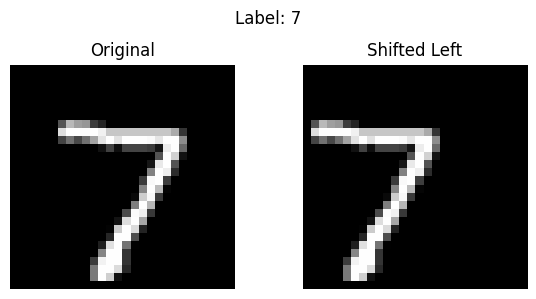

In [ ]:
import matplotlib.pyplot as plt

# Original image
sample_img, label = test_dataset[0]

# Shifted image
shifted_img = shift_left(sample_img, pixels=5)

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(sample_img.squeeze(), cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(shifted_img.squeeze(), cmap='gray')
axs[1].set_title("Shifted Left")
axs[1].axis('off')

plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.forward(shifted_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 7
Outputs: tensor([[ -3.1790,   2.6637,   1.7775,  -3.3289, -11.5759, -13.9627, -15.7783,
          10.0641,  -5.6228, -10.4615]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  shifted_img = shift_left(sample_img, pixels=5)
  prediction = model.forward(shifted_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
shifted_performance = round(num_correct * 100 / test_size, 2)
metrics['network_5']['shifted_performance'] = shifted_performance
print(f"Test shifted image dataset performance: {shifted_performance}%")

Test shifted image dataset performance: 37.25%


## Rotation

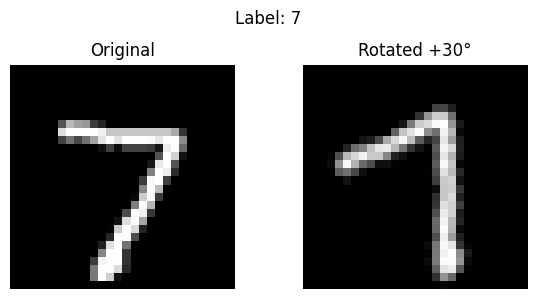

In [ ]:
# Original MNIST image
sample_img, label = test_dataset[0]

# Rotate it
rotated_img = rotate_image(sample_img, degrees=30)

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(sample_img.squeeze(), cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(rotated_img.squeeze(), cmap='gray')
axs[1].set_title("Rotated +30°")
axs[1].axis('off')

plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.forward(rotated_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 7
Outputs: tensor([[ -7.1415,  -2.8237,   0.0615,  -0.8956,  -1.7095,  -4.9370, -16.9931,
           7.0129,  -2.4431,   2.4748]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  rotated_img = rotate_image(sample_img, degrees=30)
  prediction = model.forward(rotated_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
rotated_performance = round(num_correct * 100 / test_size, 2)
metrics['network_5']['rotated_performance'] = rotated_performance
print(f"Test rotated image dataset performance: {rotated_performance}%")

Test rotated image dataset performance: 77.87%


## Scaling

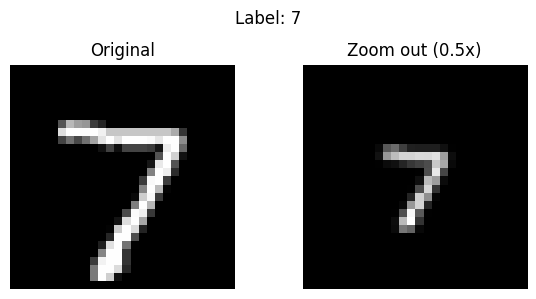

In [ ]:
# Sample image
sample_img, label = test_dataset[0]
zoomed_img = scale_image(sample_img, scale_factor=0.5)

# Plot original, zoom in, zoom out
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(sample_img.squeeze(), cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(zoomed_img.squeeze(), cmap='gray')
axs[1].set_title("Zoom out (0.5x)")
axs[1].axis('off')

plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.forward(zoomed_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 7
Outputs: tensor([[-4.3144, -0.1900,  0.1747, -1.3276, -3.5058, -1.1652, -4.0024,  0.3158,
         -1.1538,  0.0688]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  zoomed_img = scale_image(sample_img, scale_factor=0.5)
  prediction = model.forward(zoomed_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
scaled_performance = round(num_correct * 100 / test_size, 2)
metrics['network_5']['scaled_performance'] = scaled_performance
print(f"Test scaled image dataset performance: {scaled_performance}%")

Test scaled image dataset performance: 26.36%


In [ ]:
metrics['network_5']

{'name': '1 Conv + Activation + Pool layer',
 'base_performance': 98.24,
 'total_learnable_parameters': 11738,
 'shifted_performance': 37.25,
 'rotated_performance': 77.87,
 'scaled_performance': 26.36}

In [ ]:
metrics['network_4']

{'name': '1 Conv + Activation layer',
 'base_performance': 97.67,
 'total_learnable_parameters': 46298,
 'shifted_performance': 40.6,
 'rotated_performance': 77.32,
 'scaled_performance': 32.44}

Pooling operation improved model performance while decreasing the model parameters by 4x. That said, did not improve model performance on translation, scaling, rotation

# Network 6: 2 Convolution + Activation + Pooling Network

## Model Training

In [ ]:
class Conv2Blocks(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)    # [28x28] → [24x24]
        self.pool1 = nn.MaxPool2d(2, 2)                # [24x24] → [12x12]
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)   # [12x12] → [8x8]
        self.pool2 = nn.MaxPool2d(2, 2)                # [8x8] → [4x4]
        self.fc = nn.Linear(16 * 4 * 4, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        return self.fc(x)

model = train(Conv2Blocks().to(device)) # Replace with model of interest

Epoch 1/5
  Train Loss: 0.1095, Train Acc: 96.77%
  Test  Loss: 0.0995, Test  Acc: 96.95%
Epoch 2/5
  Train Loss: 0.0825, Train Acc: 97.55%
  Test  Loss: 0.0781, Test  Acc: 97.55%
Epoch 3/5
  Train Loss: 0.0607, Train Acc: 98.19%
  Test  Loss: 0.0595, Test  Acc: 98.17%
Epoch 4/5
  Train Loss: 0.0479, Train Acc: 98.57%
  Test  Loss: 0.0501, Test  Acc: 98.36%
Epoch 5/5
  Train Loss: 0.0470, Train Acc: 98.56%
  Test  Loss: 0.0505, Test  Acc: 98.42%


## Visualization

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt


def _plot_block(maps, title, n_cols=8):
    """
    Helper: maps is a list of 3 tensors [conv_out, relu_out, pool_out]
            each tensor shape [C, H, W] on CPU.
    """
    conv_out, relu_out, pool_out = maps
    channels = conv_out.size(0)
    rows_needed = (channels + n_cols - 1) // n_cols

    vmax = conv_out.abs().max().item()  # common colour range per block

    fig, axes = plt.subplots(3 * rows_needed, n_cols,
                             figsize=(2 * n_cols, 2 * 3 * rows_needed),
                             dpi=150)
    axes = axes.reshape(3 * rows_needed, n_cols)

    for c in range(channels):
        r = c // n_cols          # row group index (for channels)
        col = c %  n_cols        # column inside the group

        #     row offset for conv / relu / pool inside the group
        axes[3*r + 0, col].imshow(conv_out[c], cmap='seismic',
                                  vmin=-vmax, vmax=vmax,
                                  interpolation='nearest')
        axes[3*r + 1, col].imshow(relu_out[c], cmap='seismic',
                                  vmin=-vmax, vmax=vmax,
                                  interpolation='nearest')
        axes[3*r + 2, col].imshow(pool_out[c], cmap='seismic',
                                  vmin=-vmax, vmax=vmax,
                                  interpolation='nearest')

        # tidy
        axes[3*r + 0, col].axis('off')
        axes[3*r + 1, col].axis('off')
        axes[3*r + 2, col].axis('off')
        if col == 0:                    # add tiny row labels on left margin
            axes[3*r + 0, col].set_ylabel('Conv',  fontsize=9)
            axes[3*r + 1, col].set_ylabel('ReLU',  fontsize=9)
            axes[3*r + 2, col].set_ylabel('Pool',  fontsize=9)

    # turn off any extra axes (if channels not multiple of n_cols)
    for ax in axes.flatten()[channels:]:
        ax.axis('off')

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


def visualize_feature_maps(model, image_tensor, n_cols_b1=8, n_cols_b2=8):
    """
    Visualize Block 1  (conv1 → relu → pool1)  and
              Block 2  (conv2 → relu → pool2) activations.
    """
    model.eval()
    with torch.no_grad():
        x = image_tensor.unsqueeze(0).to(next(model.parameters()).device)

        # ---- Block 1 ----
        conv1 = model.conv1(x)              # [1,  8, 24, 24]
        relu1 = F.relu(conv1)               # [1,  8, 24, 24]
        pool1 = model.pool1(relu1)          # [1,  8, 12, 12]

        # ---- Block 2 ----
        conv2 = model.conv2(pool1)          # [1, 16,  8,  8]
        relu2 = F.relu(conv2)               # [1, 16,  8,  8]
        pool2 = model.pool2(relu2)          # [1, 16,  4,  4]

    # Move to CPU and squeeze batch dim
    block1_maps = [t.cpu().squeeze(0) for t in (conv1, relu1, pool1)]
    block2_maps = [t.cpu().squeeze(0) for t in (conv2, relu2, pool2)]

    # --- Plot ---
    _plot_block(block1_maps, "Block 1  (8 feature maps)", n_cols=n_cols_b1)
    _plot_block(block2_maps, "Block 2  (16 feature maps)", n_cols=n_cols_b2)

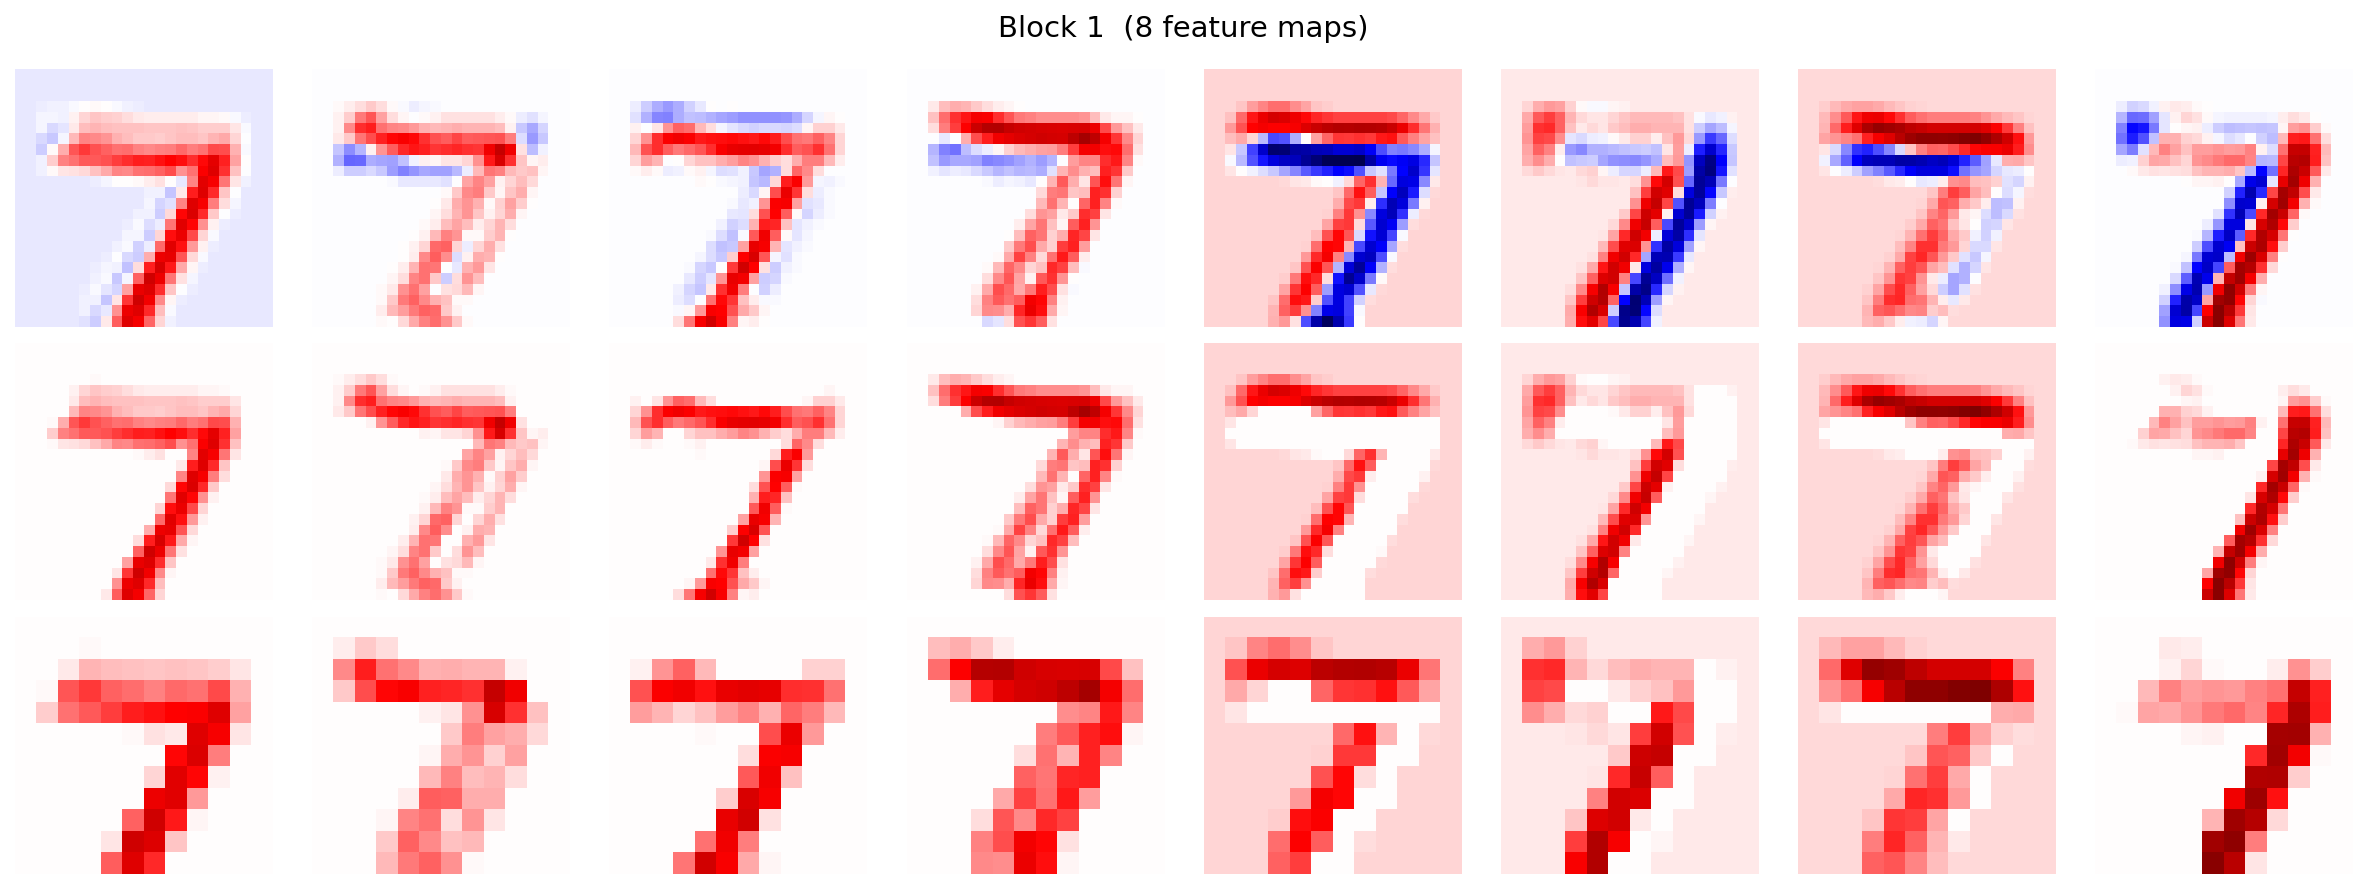

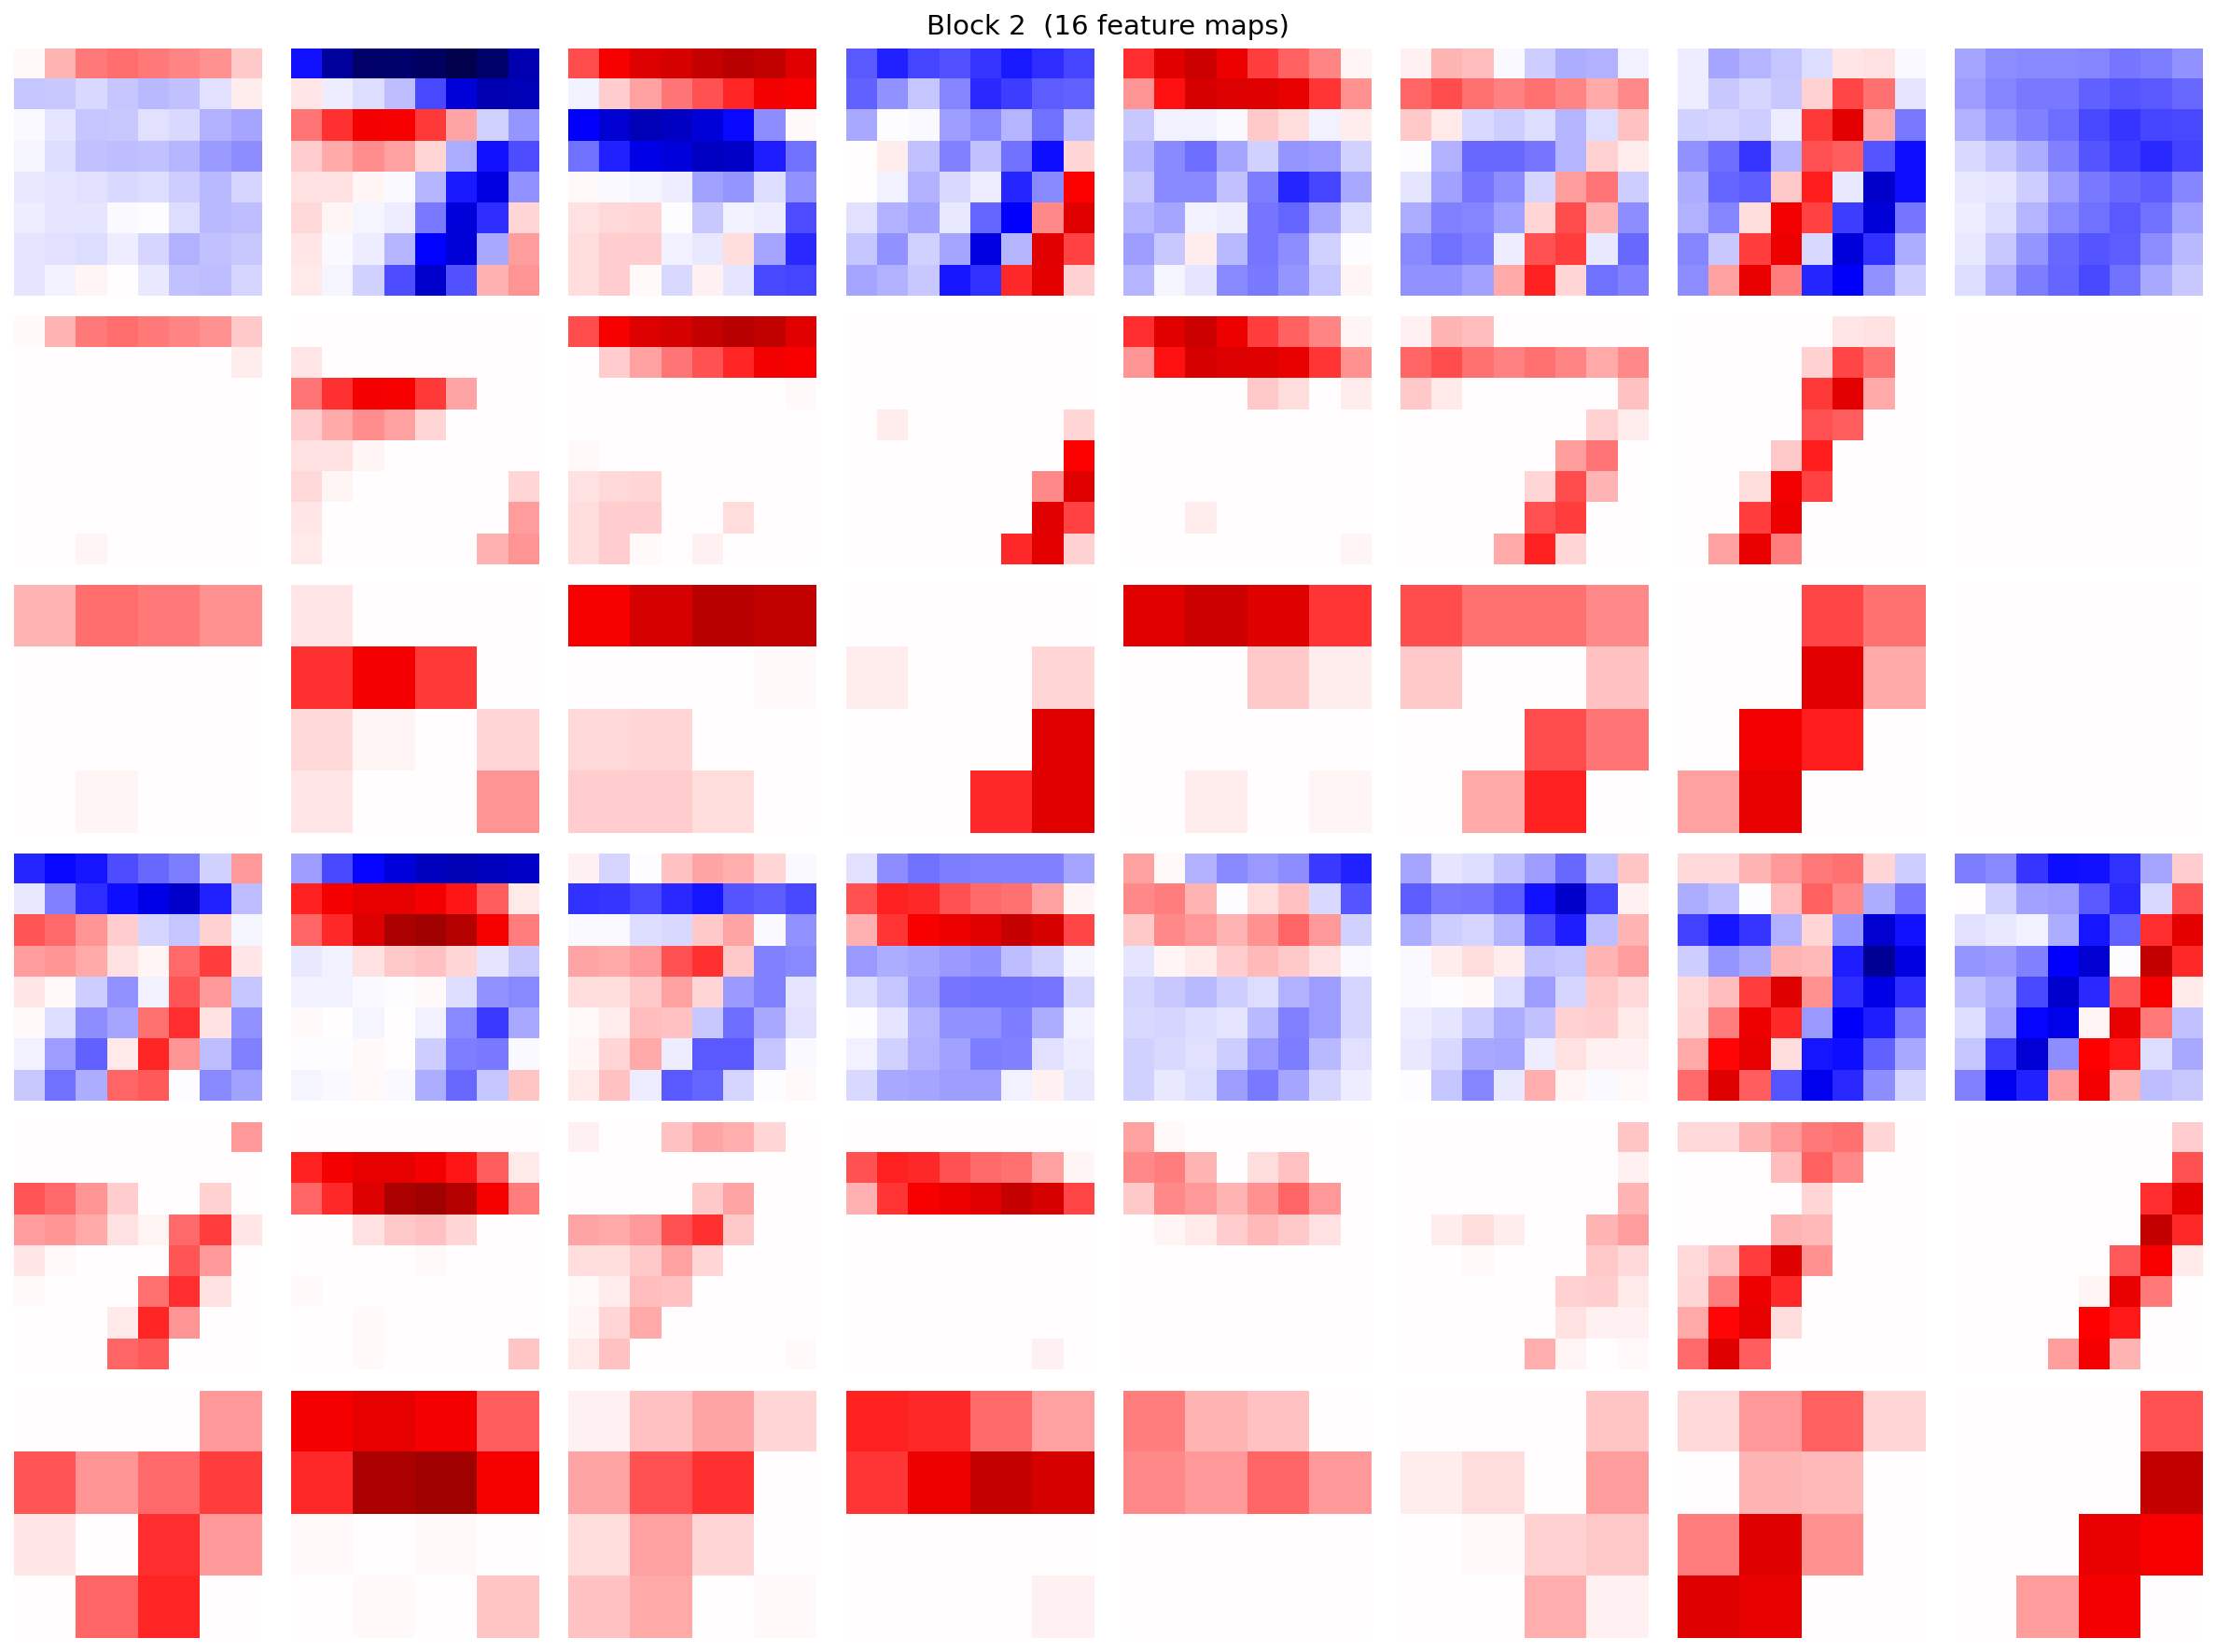

In [ ]:
sample_img, label = test_dataset[0]
visualize_feature_maps(model, sample_img)

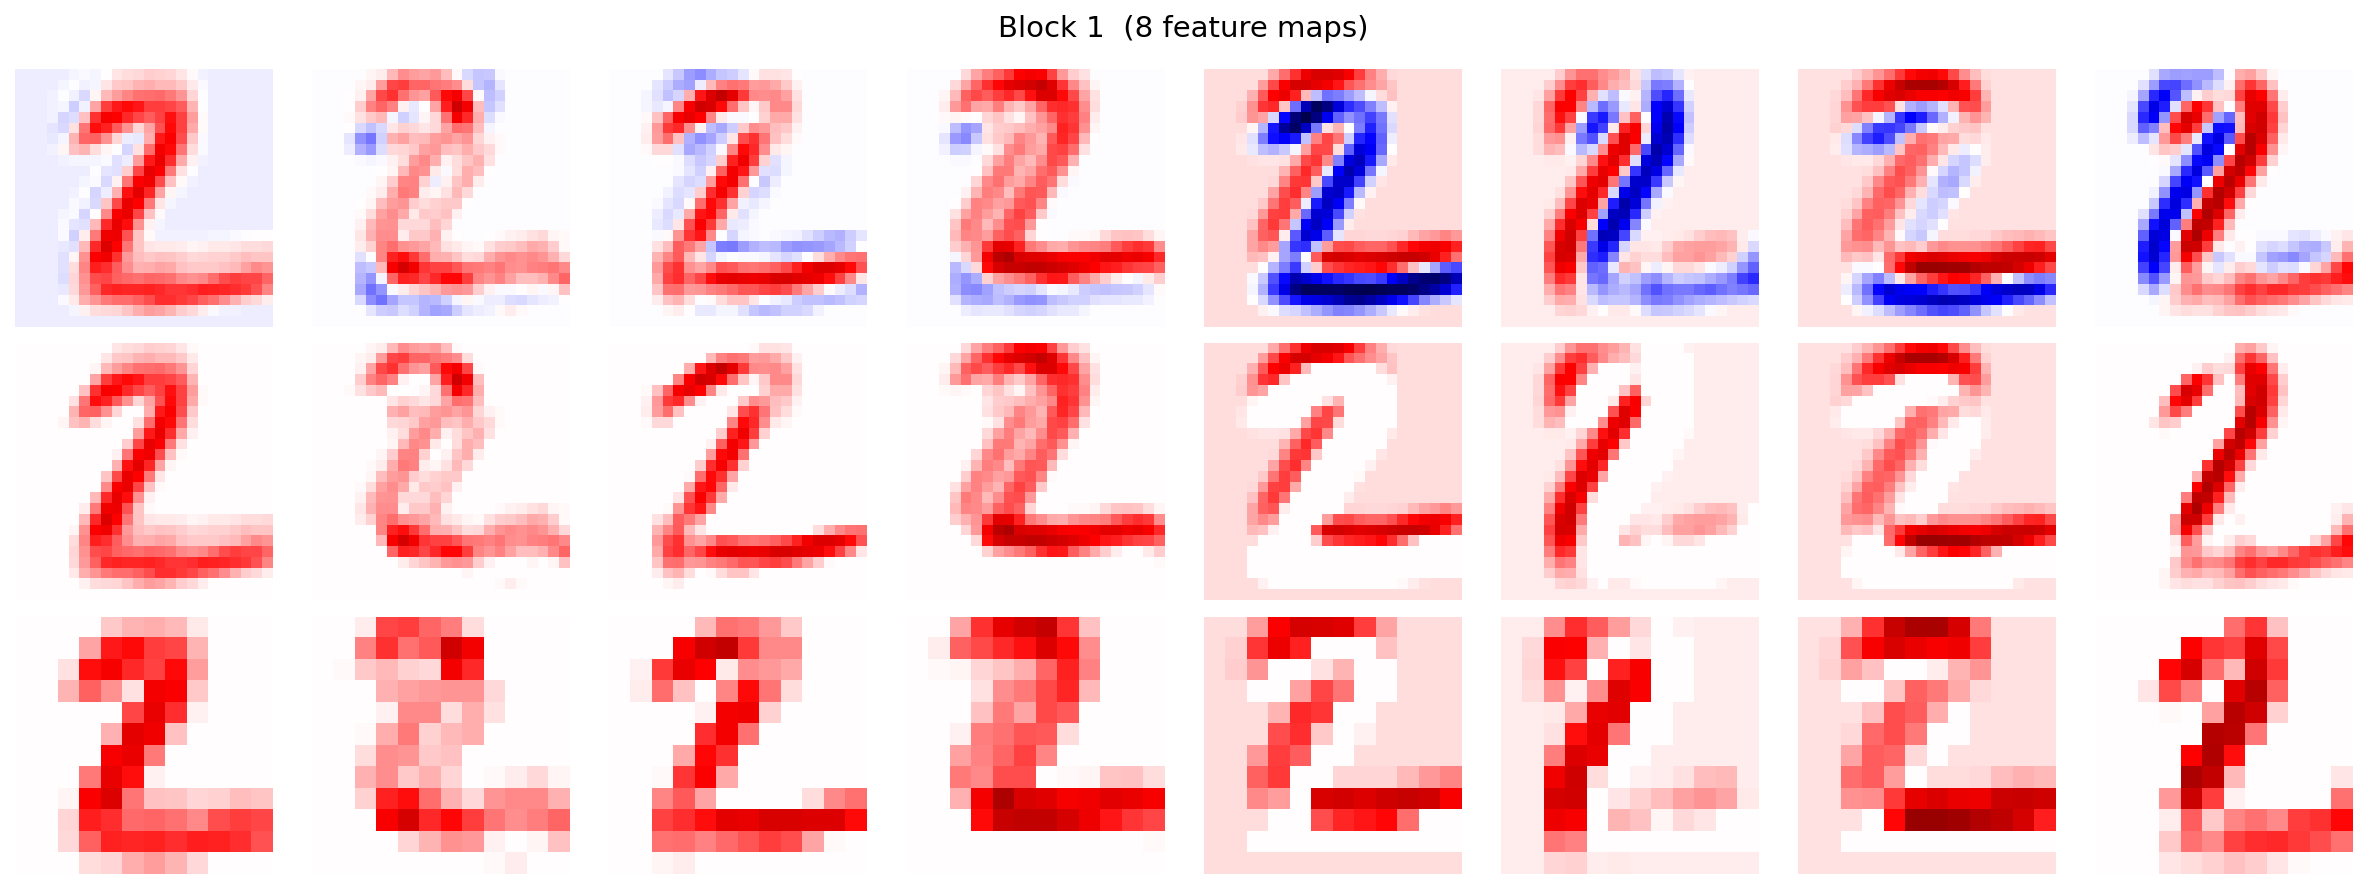

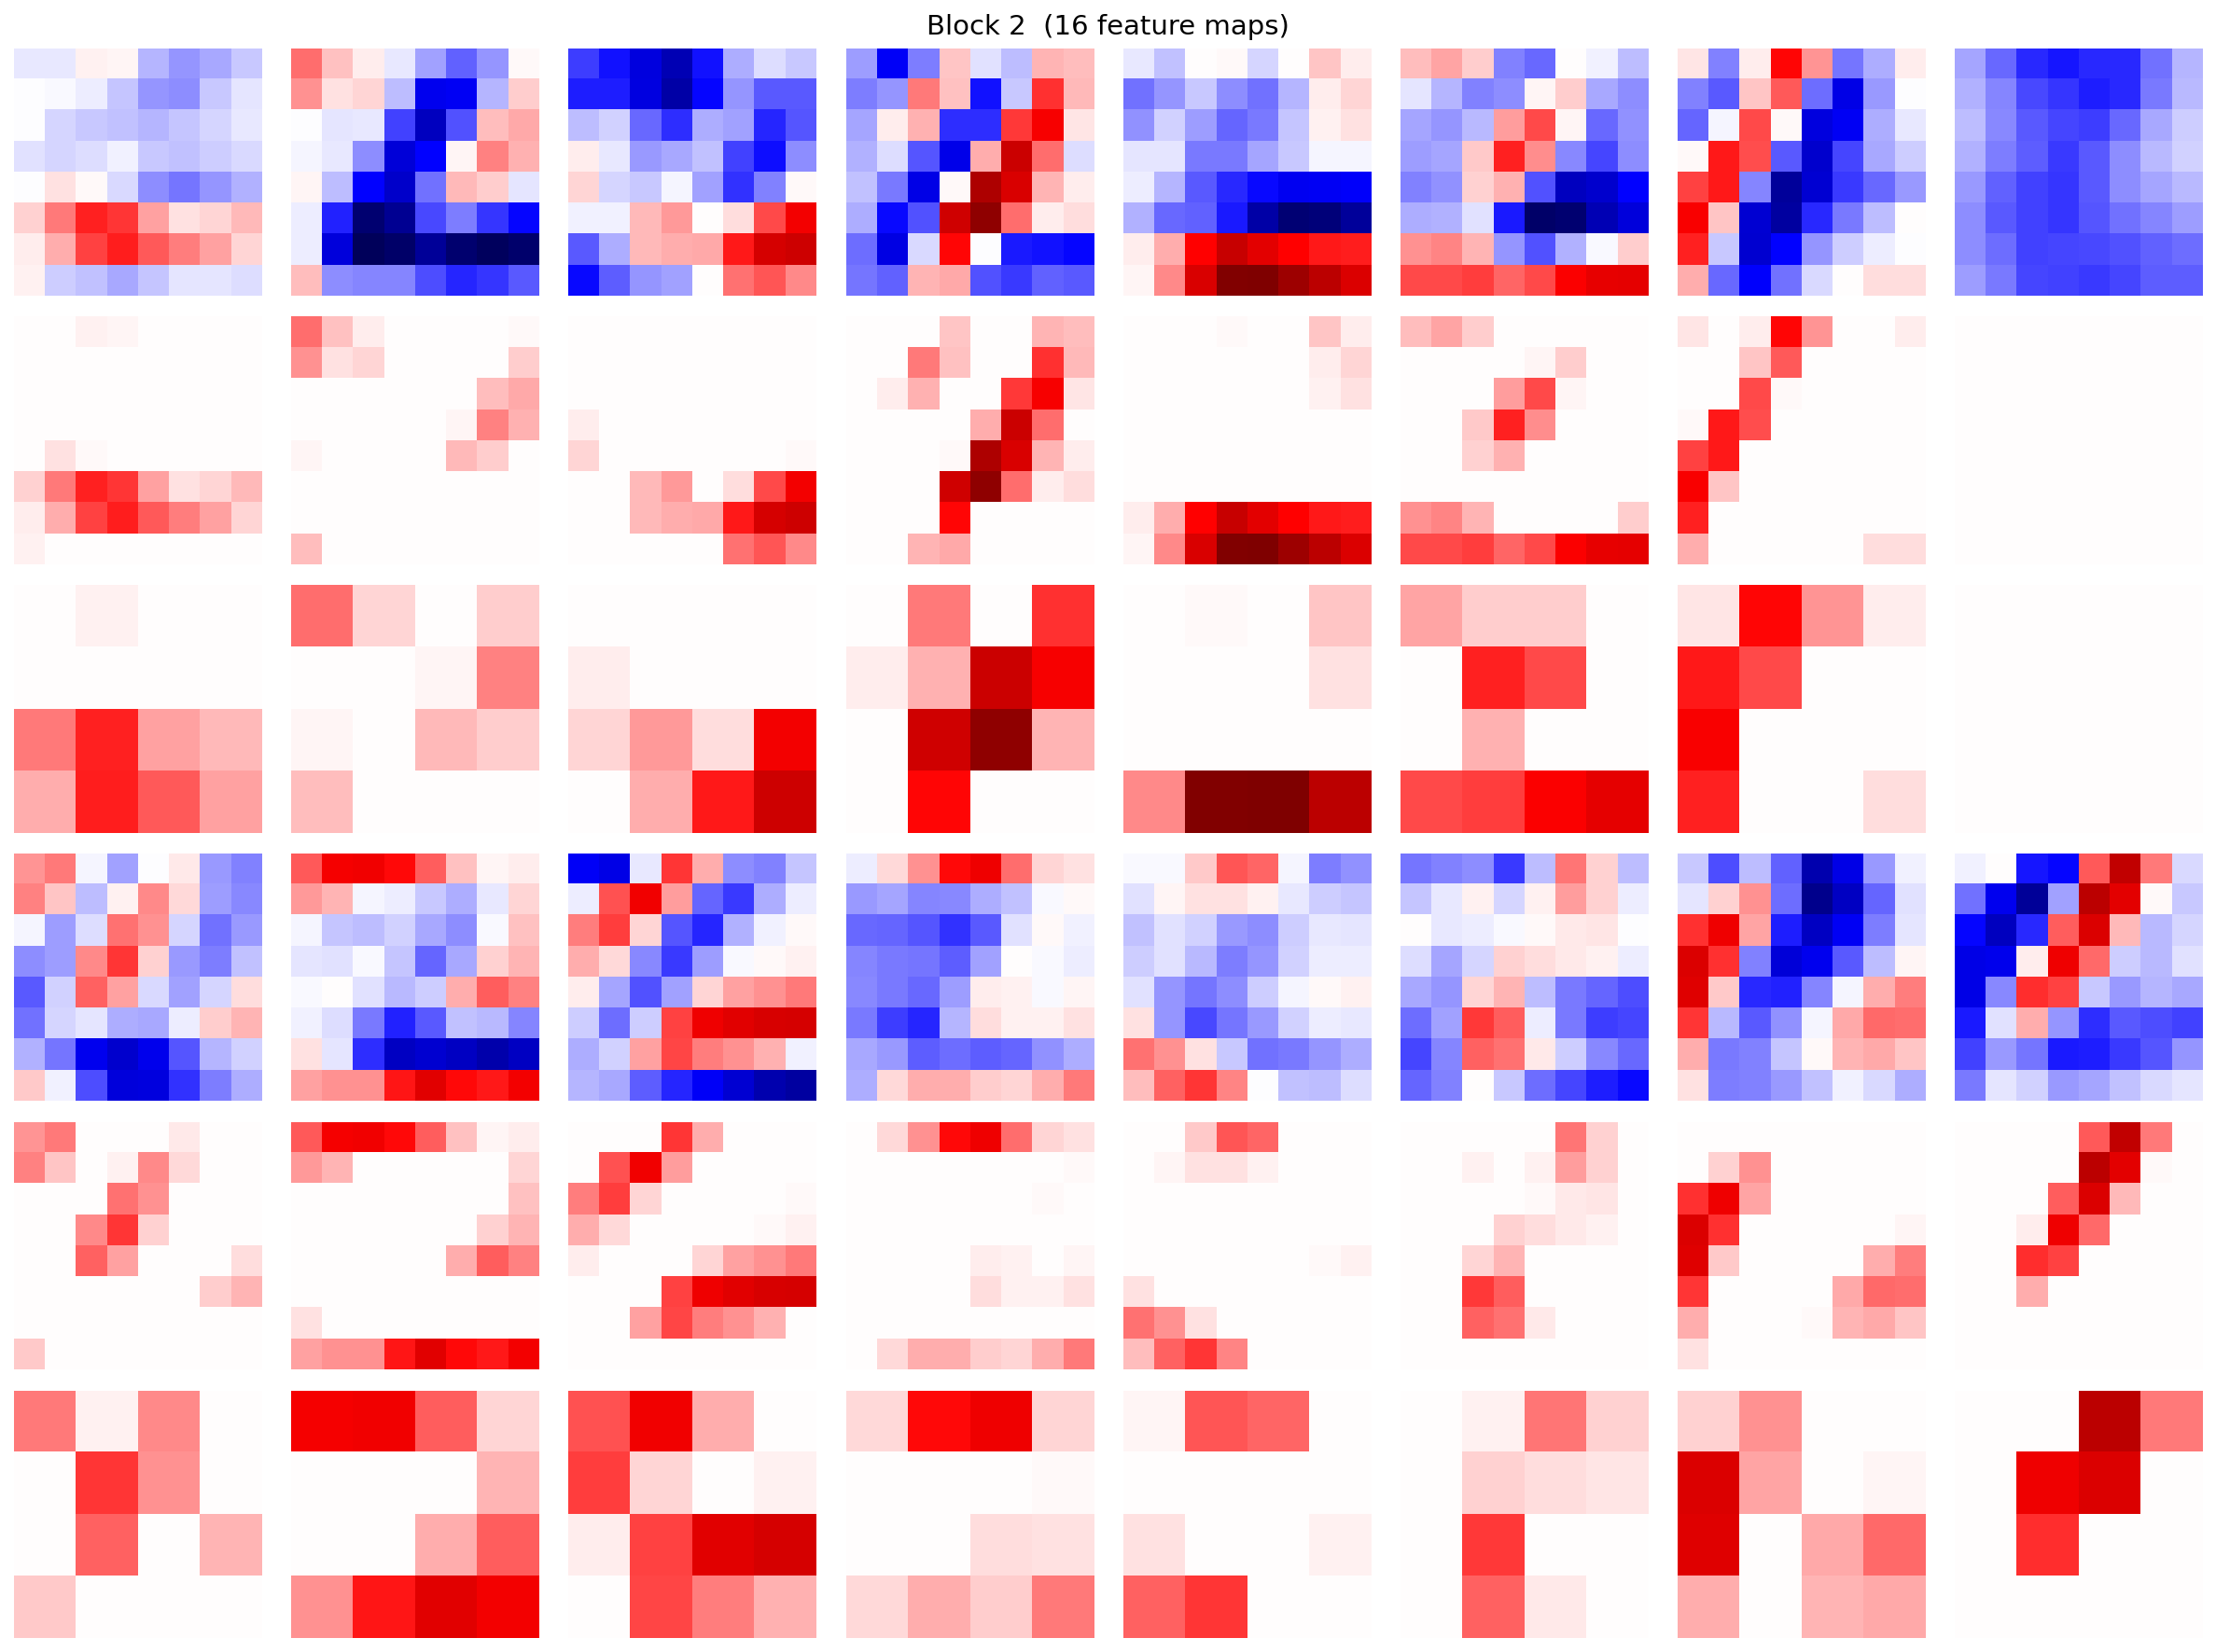

In [ ]:
sample_img, label = test_dataset[1]
visualize_feature_maps(model, sample_img)

## Base Performance

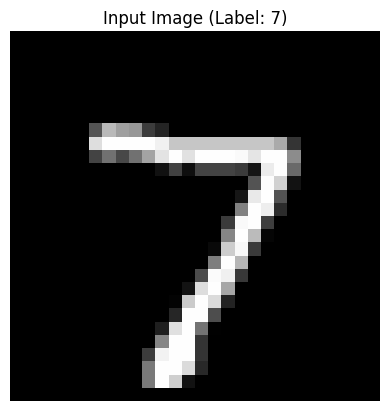

In [ ]:
# Show input
sample_img, sample_label = test_dataset[0]
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"Input Image (Label: {sample_label})")
plt.axis('off')
plt.show()

In [ ]:
predictions = model.forward(sample_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 7
Outputs: tensor([[ -7.1347,  -0.7945,   0.7202,  -0.4546,  -7.7439,  -8.0135, -19.7642,
          13.0688,  -7.0823,  -0.0826]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  prediction = model.forward(sample_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
base_performance = round(num_correct * 100 / test_size, 2)
total_learnable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

metrics['network_6'] = {
    'name': '2 Conv + Activation + Pool layers',
    'base_performance': base_performance,
    'total_learnable_parameters': total_learnable_parameters
}

print(f"Base image dataset performance: {base_performance}%")
print(f"Total trainable parameters: {total_learnable_parameters:,}")

Base image dataset performance: 98.73%
Total trainable parameters: 5,994


## Shifting

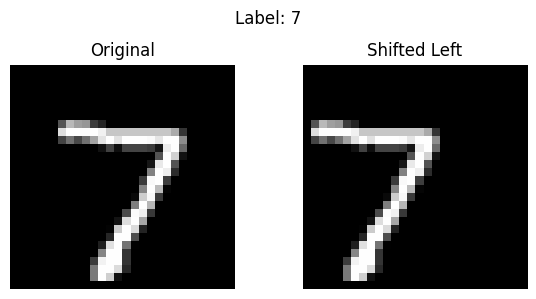

In [ ]:
import matplotlib.pyplot as plt

# Original image
sample_img, label = test_dataset[0]

# Shifted image
shifted_img = shift_left(sample_img, pixels=5)

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(sample_img.squeeze(), cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(shifted_img.squeeze(), cmap='gray')
axs[1].set_title("Shifted Left")
axs[1].axis('off')

plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.forward(shifted_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 7
Outputs: tensor([[ -4.1472,   6.0641,   1.8430,  -4.5592,  -6.7360,  -6.8263, -15.5443,
           9.4089,  -2.5335,  -5.0658]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  shifted_img = shift_left(sample_img, pixels=5)
  prediction = model.forward(shifted_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
shifted_performance = round(num_correct * 100 / test_size, 2)
metrics['network_6']['shifted_performance'] = shifted_performance
print(f"Test shifted image dataset performance: {shifted_performance}%")

Test shifted image dataset performance: 49.23%


## Rotation

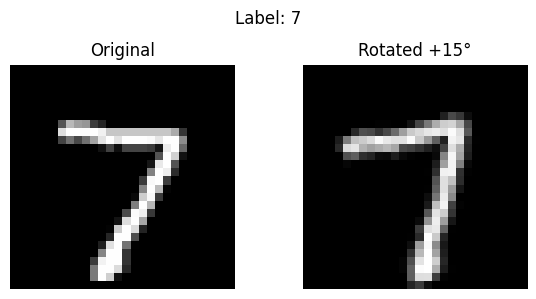

In [ ]:
# Original MNIST image
sample_img, label = test_dataset[0]

# Rotate it
rotated_img = rotate_image(sample_img, degrees=15)

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(sample_img.squeeze(), cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(rotated_img.squeeze(), cmap='gray')
axs[1].set_title("Rotated +15°")
axs[1].axis('off')

plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.forward(rotated_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 7
Outputs: tensor([[ -8.7412,  -0.2339,  -3.2570,  -1.3392,  -1.9772,  -6.1027, -20.0988,
          11.6587,  -7.3452,   2.5152]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  rotated_img = rotate_image(sample_img, degrees=30)
  prediction = model.forward(rotated_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
rotated_performance = round(num_correct * 100 / test_size, 2)
metrics['network_6']['rotated_performance'] = rotated_performance
print(f"Test rotated image dataset performance: {rotated_performance}%")

Test rotated image dataset performance: 81.61%


## Scaling

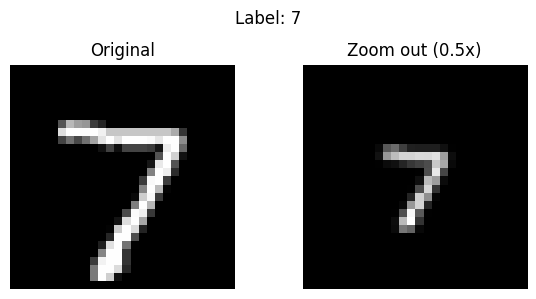

In [ ]:
# Sample image
sample_img, label = test_dataset[0]
zoomed_img = scale_image(sample_img, scale_factor=0.5)

# Plot original, zoom in, zoom out
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(sample_img.squeeze(), cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(zoomed_img.squeeze(), cmap='gray')
axs[1].set_title("Zoom out (0.5x)")
axs[1].axis('off')

plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.forward(zoomed_img.unsqueeze(0).to(device))
print(f"Prediction: {predictions.argmax().item()}")
print(f"Outputs: {predictions}")

Prediction: 9
Outputs: tensor([[-3.9733, -2.7839, -0.8187, -0.5699, -3.6093, -1.2697, -4.2761, -0.1755,
         -2.7605,  0.5804]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
num_correct = 0
test_size = 10_000

for i in range(test_size):
  sample_img, label = test_dataset[i]
  zoomed_img = scale_image(sample_img, scale_factor=0.5)
  prediction = model.forward(zoomed_img.unsqueeze(0).to(device)).argmax().item()
  if prediction == label:
    num_correct += 1

In [ ]:
scaled_performance = round(num_correct * 100 / test_size, 2)
metrics['network_6']['scaled_performance'] = scaled_performance
print(f"Test scaled image dataset performance: {scaled_performance}%")

Test scaled image dataset performance: 42.48%


# Conclusion

In [ ]:
metrics

{'network_1': {'name': 'no hidden layers',
  'base_performance': 92.35,
  'total_learnable_parameters': 7850,
  'shifted_performance': 16.01,
  'rotated_performance': 55.29,
  'scaled_performance': 18.51},
 'network_2': {'name': '1 hidden layer',
  'base_performance': 96.59,
  'total_learnable_parameters': 50890,
  'shifted_performance': 26.79,
  'rotated_performance': 69.45,
  'scaled_performance': 20.72},
 'network_3': {'name': '1 Conv layer',
  'base_performance': 91.93,
  'total_learnable_parameters': 46298,
  'shifted_performance': 14.26,
  'rotated_performance': 54.49,
  'scaled_performance': 17.95},
 'network_4': {'name': '1 Conv + Activation layer',
  'base_performance': 97.67,
  'total_learnable_parameters': 46298,
  'shifted_performance': 40.6,
  'rotated_performance': 77.32,
  'scaled_performance': 32.44},
 'network_5': {'name': '1 Conv + Activation + Pool layer',
  'base_performance': 98.24,
  'total_learnable_parameters': 11738,
  'shifted_performance': 37.25,
  'rotated_p

In [ ]:
import pandas as pd
df = pd.DataFrame.from_dict(metrics, orient="index").reset_index() \
                 .rename(columns={"index": "network"})

In [ ]:
df

,network,name,base_performance,total_learnable_parameters,shifted_performance,rotated_performance,scaled_performance
0,network_1,no hidden layers,92.35,7850,16.01,55.29,18.51
1,network_2,1 hidden layer,96.59,50890,26.79,69.45,20.72
2,network_3,1 Conv layer,91.93,46298,14.26,54.49,17.95
3,network_4,1 Conv + Activation layer,97.67,46298,40.60,77.32,32.44
4,network_5,1 Conv + Activation + Pool layer,98.24,11738,37.25,77.87,26.36
5,network_6,2 Conv + Activation + Pool layers,98.73,5994,49.23,81.61,42.48


- **Convolution** increases the quality of the features specific to image inputs (seen by comparing network 2 to network 4).
- **Non-linear Activation** adds expressiveness to the model, increasing performance with no increase in tranable parameters. (seen comparing network_3 to network_4)
- **Pool** layers are great for downsampling while preserving network performance, even on transformations.(seen by comparing network 4 to network 5)
- **Stacking Conv + Activation + Pooling blocks** together gives the best outcome for classifying input images even when transformed while minimizing the number of learnable parameters.